# ARIMA Models 

* Predict and visualize future values and calculate confidence level for the predictions 


2. A non-stationary series with significant dependence among values, but no seasonality. In this case we can use ARMA models after we detrended, or we can use an **integrated** ARMA model that detrends for us.





In [98]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm 
import matplotlib.pyplot as plt


In [2]:
#Load the dataset 
df = pd.read_csv('../../data/raw/zillow_data.csv')

In [3]:
def one_zipcode(df, zipcode, index = None):
    """This function pulls the data for one zipcode at a time and retuns a DataFrame for using in Prophet.
    
    inputs:
    df: dataframe of zipcodes and time series in wide format
    zipcode: A particular zipcode of interest. 
    index: index of a zipcode of interest. Defaults to none.
    
    Output:
    A pandas dataframe time series of the zipcode in long format. 
    """
    if index != None: #if input is index number and not zipcode
        series = df.iloc[index]
    else:
        series = df.loc[df['RegionName'] == zipcode] #if input is zipcode and not index
        series = series.iloc[0]
        
    series_data = series.iloc[7:]
    df_series = pd.DataFrame(series_data.values, index = series_data.index, columns = ['y'])
    df_series.index = pd.to_datetime(df_series.index, yearfirst = True, format = '%Y-%m')
    df_series['ds'] = df_series.index
    df_series.reset_index(drop = True, inplace = True)
    df_series['y'] = df_series['y'].astype('int64', errors='ignore')
    return df_series

In [4]:
def prep_zip_for_ARIMA(df, zipcode):
    """
    Prepares a dataframe to be put into an ARIMA Model by providing the large dataframe of all the zipcodes.
    
    input:
    df : a pandas dataframe with time series and median home value for all of the zipcodes. 
    
    output:
    df_zip : a dataframe with na's dropped, the datetime column set to the index, and the median home value cast to int64
    """
    
    df_zip = one_zipcode(df, zipcode= zipcode)
    df_zip.set_index('ds', inplace=True)
    df_zip.dropna(inplace=True)
    df_zip['y'] = df_zip['y'].astype({'y': 'int64'})
    return df_zip

In [5]:
df_zip = prep_zip_for_ARIMA(df,34982 )

## The ARIMA Time Series Model

The ARIMA model, which stands for **AutoregRessive Integrated Moving Average**. ARIMA is a model that can be fitted to time series data in order to better understand or predict future points in the series.



A detailed article on these parameters is available [HERE](https://www.quantstart.com/articles/Autoregressive-Integrated-Moving-Average-ARIMA-p-d-q-Models-for-Time-Series-Analysis).



## Parameter Selection for the ARIMA Time Series Model


The first step towards fitting an ARIMA model is to find the values of `ARIMA(p,d,q)(P,D,Q)s` that produce the desired output. We will first generate small ranges of these parameters and use a "grid search" to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the `SARIMAX()` function from the statsmodels module and assess its overall quality. 

`SARIMAX` detailed documentation can be viewed [here](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)


In [8]:
def get_param_combos(max_range=None, p_max=None ,d_max=None, q_max=None):
    """
    Creates the p,d,q combos for an ARIMA model grid search
    
    inputs:
    max_range: input max range if you want all three parameters to have the same number of possible combos, otherwise
    specify with the other KWARGS
        
    """
    
    if max_range != None:
        p_max = d_max = q_max = range(0, max_range)
        pdq = list(itertools.product(p_max,d_max,q_max))
        return pdq
    else:
        p_max = range(0,p_max)
        q_max = range(0,q_max)
        d_max = range(0,d_max)
        pdq = list(itertools.product(p_max,d_max,q_max))
        return pdq

In [9]:
def ARIMA_param_gridsearch(df, pdq_combo_list):
    
    """
    Finds the optimum p,d,q parameters for an ARIMA model using AIC as the metric
    
    inputs:
    df: the dataframe to be modeled
    pdq_combo_list: list of possible pdq combinations
    
    returns: prints optimum combo with corresponding AIC and returns a tuple of the ideal combo
    """
    

    ans = []
    for comb in pdq_combo_list:
        
        mod = sm.tsa.statespace.SARIMAX(df,
                                    order=(comb),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)                                      
        output = mod.fit()
        ans.append([comb, output.aic])
        print('ARIMA {} : AIC Calculated ={}'.format(comb, output.aic))
    
    ans_df = pd.DataFrame(ans, columns=['pdq', 'aic'])
    print(ans_df.loc[ans_df['aic'].idxmin()])
    return ans_df.loc[ans_df['aic'].idxmin()][0]
   

## AIC (Akaike Information Criterion) as Regularization Measure


For evaluating the model, we shall use the AIC (Akaike Information Criterion) value. The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection. 

A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value. 

NOTE: 

* An overview of Akaike Information Criterion can be viewed [HERE](http://www.statisticshowto.com/akaikes-information-criterion/)



In [10]:
combo = ARIMA_param_gridsearch(df_zip, get_param_combos(5))

/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) : AIC Calculated =6867.986508733736
ARIMA (0, 0, 1) : AIC Calculated =12774.799643436323


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 2) : AIC Calculated =6533.073548811351
ARIMA (0, 0, 3) : AIC Calculated =8307.754655571858


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 4) : AIC Calculated =7652.546447384641
ARIMA (0, 1, 0) : AIC Calculated =4720.640987812769
ARIMA (0, 1, 1) : AIC Calculated =4361.456573244114


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) : AIC Calculated =4095.9445126862433


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 3) : AIC Calculated =3941.753971983573


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (0, 1, 4) : AIC Calculated =3891.855714339726
ARIMA (0, 2, 0) : AIC Calculated =3761.2093269636357
ARIMA (0, 2, 1) : AIC Calculated =3689.008230522384
ARIMA (0, 2, 2) : AIC Calculated =3674.353961656657
ARIMA (0, 2, 3) : AIC Calculated =3656.4220405286064


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 4) : AIC Calculated =3638.2637850600017
ARIMA (0, 3, 0) : AIC Calculated =3819.3993941906656
ARIMA (0, 3, 1) : AIC Calculated =3770.3471931559616
ARIMA (0, 3, 2) : AIC Calculated =3670.528280582548


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 3, 3) : AIC Calculated =3655.516135301209
ARIMA (0, 3, 4) : AIC Calculated =3632.9192157361044
ARIMA (0, 4, 0) : AIC Calculated =4004.5272920297634


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 4, 1) : AIC Calculated =3829.582363934281
ARIMA (0, 4, 2) : AIC Calculated =3833.2007592502478


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 4, 3) : AIC Calculated =3697.694731825566


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 4, 4) : AIC Calculated =3671.052881413576
ARIMA (1, 0, 0) : AIC Calculated =4731.94474097475
ARIMA (1, 0, 1) : AIC Calculated =4518.039961728465


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 2) : AIC Calculated =4107.6875486030585


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 3) : AIC Calculated =4335.346166862335


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (1, 0, 4) : AIC Calculated =4382.70855742136
ARIMA (1, 1, 0) : AIC Calculated =3774.8913709547787
ARIMA (1, 1, 1) : AIC Calculated =3703.496310525852
ARIMA (1, 1, 2) : AIC Calculated =3686.932748628898
ARIMA (1, 1, 3) : AIC Calculated =3669.5902364326093
ARIMA (1, 1, 4) : AIC Calculated =3650.461705735601
ARIMA (1, 2, 0) : AIC Calculated =3732.307214579522


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) : AIC Calculated =3687.90888126692
ARIMA (1, 2, 2) : AIC Calculated =3676.1500419908825
ARIMA (1, 2, 3) : AIC Calculated =3655.8366948502808


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 4) : AIC Calculated =3639.081169593167
ARIMA (1, 3, 0) : AIC Calculated =3818.6866308810995
ARIMA (1, 3, 1) : AIC Calculated =3718.618268363522


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 3, 2) : AIC Calculated =3669.9718801560557


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 3, 3) : AIC Calculated =3658.382474038336


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 3, 4) : AIC Calculated =3634.063315477921
ARIMA (1, 4, 0) : AIC Calculated =3979.940797072775
ARIMA (1, 4, 1) : AIC Calculated =3826.070601486267


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 4, 2) : AIC Calculated =3821.3837801483733


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 4, 3) : AIC Calculated =3695.256178722168


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmo

ARIMA (1, 4, 4) : AIC Calculated =3667.2350147822044
ARIMA (2, 0, 0) : AIC Calculated =3774.9832142932737
ARIMA (2, 0, 1) : AIC Calculated =3761.319308045785
ARIMA (2, 0, 2) : AIC Calculated =3702.999207450971
ARIMA (2, 0, 3) : AIC Calculated =3687.7993225144796


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (2, 0, 4) : AIC Calculated =3669.6584274376946
ARIMA (2, 1, 0) : AIC Calculated =3730.7441095826243
ARIMA (2, 1, 1) : AIC Calculated =3700.112232656249
ARIMA (2, 1, 2) : AIC Calculated =3688.891888017126


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 3) : AIC Calculated =3668.898439391325


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 4) : AIC Calculated =3646.664881262992
ARIMA (2, 2, 0) : AIC Calculated =3690.5264267799844
ARIMA (2, 2, 1) : AIC Calculated =3688.9072534572006


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) : AIC Calculated =3670.31030635671


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 3) : AIC Calculated =3650.19215894902


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 4) : AIC Calculated =3637.187846408389
ARIMA (2, 3, 0) : AIC Calculated =3713.38738508552
ARIMA (2, 3, 1) : AIC Calculated =3707.6498727761546


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 3, 2) : AIC Calculated =3665.92569478946


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 3, 3) : AIC Calculated =3657.685690553865


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (2, 3, 4) : AIC Calculated =3625.9688672664915
ARIMA (2, 4, 0) : AIC Calculated =3868.2143809318277
ARIMA (2, 4, 1) : AIC Calculated =3762.6881010736233
ARIMA (2, 4, 2) : AIC Calculated =3726.4472459215754


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 4, 3) : AIC Calculated =3654.4451734117592


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 4, 4) : AIC Calculated =3650.8270427346442
ARIMA (3, 0, 0) : AIC Calculated =3732.2276004756277
ARIMA (3, 0, 1) : AIC Calculated =3703.7061408908708


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmo

ARIMA (3, 0, 2) : AIC Calculated =3710.219767205485
ARIMA (3, 0, 3) : AIC Calculated =3689.692012126936


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (3, 0, 4) : AIC Calculated =3675.167775319378
ARIMA (3, 1, 0) : AIC Calculated =3690.7709386846627
ARIMA (3, 1, 1) : AIC Calculated =3688.947602850443
ARIMA (3, 1, 2) : AIC Calculated =3690.7351299836223
ARIMA (3, 1, 3) : AIC Calculated =3659.381865261374


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 4) : AIC Calculated =3649.8182868797016
ARIMA (3, 2, 0) : AIC Calculated =3661.7449726227815
ARIMA (3, 2, 1) : AIC Calculated =3663.453363346621
ARIMA (3, 2, 2) : AIC Calculated =3665.2857156178898


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 3) : AIC Calculated =3653.5126869932083


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 4) : AIC Calculated =3636.66242336863
ARIMA (3, 3, 0) : AIC Calculated =3688.10401824667


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 3, 1) : AIC Calculated =3656.28074226483


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 3, 2) : AIC Calculated =3658.278703408905


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 3, 3) : AIC Calculated =3645.5714564023633


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 3, 4) : AIC Calculated =3628.9473275592127
ARIMA (3, 4, 0) : AIC Calculated =3799.9469837831507
ARIMA (3, 4, 1) : AIC Calculated =3740.5416312162342


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 4, 2) : AIC Calculated =3742.116025938887


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 4, 3) : AIC Calculated =3656.6135135810086


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 4, 4) : AIC Calculated =3653.07740001886
ARIMA (4, 0, 0) : AIC Calculated =3691.203965614214


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 0, 1) : AIC Calculated =3709.3744673521132
ARIMA (4, 0, 2) : AIC Calculated =3691.703031940615


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 0, 3) : AIC Calculated =3689.914349202861


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 0, 4) : AIC Calculated =3674.7795902039466
ARIMA (4, 1, 0) : AIC Calculated =3660.6005764059337
ARIMA (4, 1, 1) : AIC Calculated =3662.2101828801574
ARIMA (4, 1, 2) : AIC Calculated =3663.901294909306


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 1, 3) : AIC Calculated =3674.0564576989173


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 1, 4) : AIC Calculated =3644.5541085946425
ARIMA (4, 2, 0) : AIC Calculated =3649.9658871740453
ARIMA (4, 2, 1) : AIC Calculated =3651.693966824964


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 2, 2) : AIC Calculated =3663.102875402782
ARIMA (4, 2, 3) : AIC Calculated =3655.2061546082555


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 2, 4) : AIC Calculated =3643.135057197148
ARIMA (4, 3, 0) : AIC Calculated =3671.774949766621
ARIMA (4, 3, 1) : AIC Calculated =3643.0544455593194


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 3, 2) : AIC Calculated =3644.642244483446


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 3, 3) : AIC Calculated =3646.7780614450962


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 3, 4) : AIC Calculated =3630.6729966944513
ARIMA (4, 4, 0) : AIC Calculated =3769.1582577867566
ARIMA (4, 4, 1) : AIC Calculated =3706.7227598171903


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 4, 2) : AIC Calculated =3736.1061711415723


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 4, 3) : AIC Calculated =3654.5190677683477
ARIMA (4, 4, 4) : AIC Calculated =3647.1373031733606
pdq    (2, 3, 4)
aic      3625.97
Name: 69, dtype: object


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


## Fitting an ARIMA Time Series Model

Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.



In [11]:
def ARIMA_MODEL(df, params):
    """
    fits an ARIMA model to the input df using the params (tuple) to define p,d,q
    """
    
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df,
                                order=params,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    output = ARIMA_MODEL.fit()




    # Fit the model and print results
    print(output.summary().tables[1])
    
    output.plot_diagnostics(figsize=(15, 18))
    plt.show()
    
    return output
    
    

/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4371      0.033    -13.073      0.000      -0.503      -0.372
ar.L2         -0.9590      0.031    -31.018      0.000      -1.020      -0.898
ma.L1          0.0047      0.301      0.016      0.988      -0.585       0.594
ma.L2          0.1194      0.298      0.401      0.689      -0.465       0.704
ma.L3         -0.7325      0.342     -2.141      0.032      -1.403      -0.062
ma.L4         -0.3928      0.144     -2.727      0.006      -0.675      -0.111
sigma2       7.15e+04   2.31e+04      3.099      0.002    2.63e+04    1.17e+05


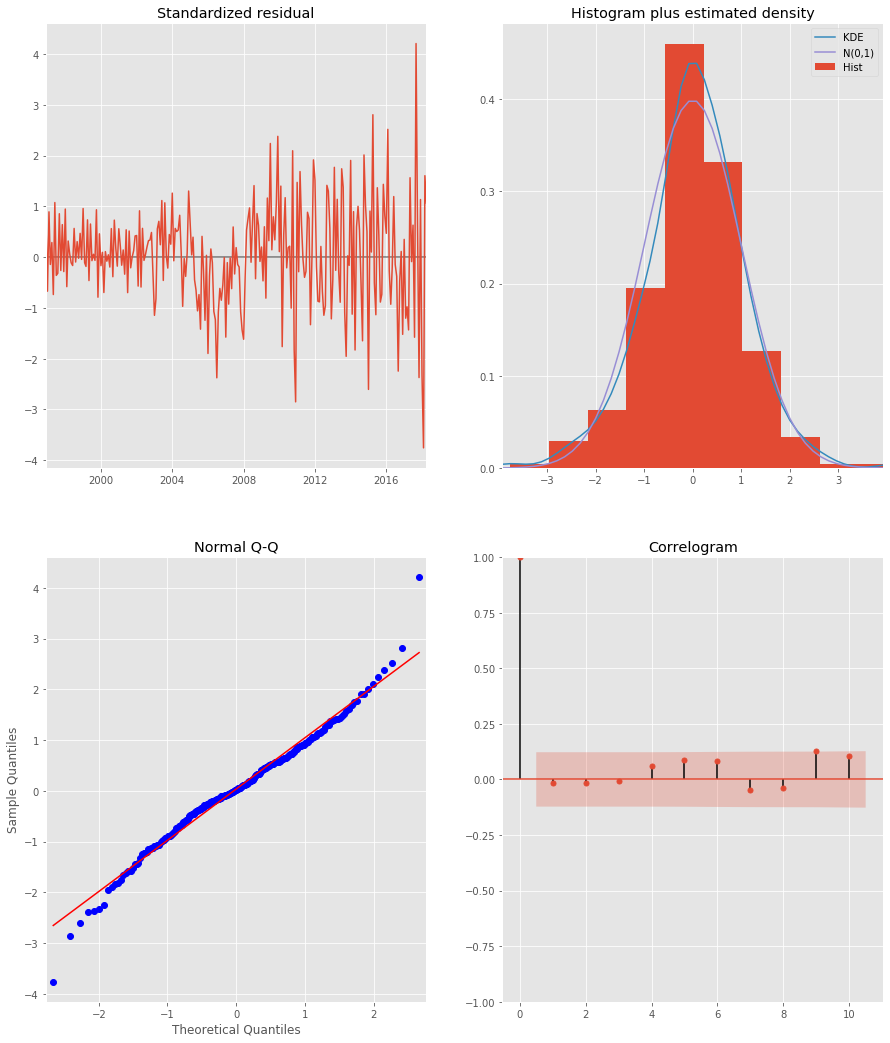

In [12]:
output = ARIMA_MODEL(df_zip, combo)

The purpose here to ensure that residuals remain uncorrelated, normally distributed having zero mean. In the absence of these assumptions, we can not move forward and need further tweaking of the model.

Let's check for these assumptions from diagnostics plots.

The purpose here to ensure that residuals remain uncorrelated, normally distributed having zero mean. In the absence of these assumptions, we can not move forward and need further tweaking of the model.

- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

- In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

- The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.


Those observations lead us to conclude that our model produces has no correlations and provides a satisfactory fit to help forecast future values.

### Validating the Model

In order to validate the model, we start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts.

In [13]:
def get_forecast_startdate(df):
    """
    helper function to get the first date of observed data from the zip code dataframe
    """
    return df.index[5]
    
def ARIMA_predictions(df, estimator):
    """
    create ARIMA model predictions and confidence intervals
    
    input: time series df used to fit the estimator
    estimator: ARIMA model used to create the predictions
    
    """
    start_date = get_forecast_startdate(df)
    
    pred = estimator.get_prediction(start=pd.to_datetime(start_date),  dynamic=False)
    
    pred_conf = pred.conf_int()
    
    return pred, pred_conf 

In [14]:
pred, pred_conf = ARIMA_predictions(df_zip, output)

In [150]:
def plot_model_validation(predictions, prediction_confidence_intervals, observed_values_df, df_original, zipcode=None):
    
    """Plot real vs predicted values along with confidence interval"""
    figsize=(10, 6)
    
    
    fig = plt.figure(figsize= figsize , facecolor='w')
    ax = fig.add_subplot(111)
    
    #Plot observed values
    observed_values_df[get_forecast_startdate(observed_values_df):].plot(ax=ax, label='observed', ls='dotted', c='black')

    #Plot predicted values
    predictions.predicted_mean.plot(ax=ax, label='Forecast', color='#0072B2', alpha=.8)

    # Plot the range for confidence intervals
    ax.fill_between(prediction_confidence_intervals.index,
                    prediction_confidence_intervals.iloc[:, 0],
                    prediction_confidence_intervals.iloc[:, 1], color='#0072B2', alpha=.2)

    #Set axes labels
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Median Home Price')
    plt.xlim(right=observed_values_df.index[-1])
    plt.ylim(bottom = 0,
            top = predictions.predicted_mean.max()+100000)
    
    #get info for title
    city = list(df_original[df_original['RegionName'] == zipcode]['City'])[0]
    state = list(df_original[df_original['RegionName'] == zipcode]['State'])[0]
    RMSE = ARIMA_rmse(predictions, observed_values_df)
    
    
    plt.legend()
    plt.title(f"ARIMA Model validation on median home sale price for {city}, {state}, {zipcode} \n  RMSE: {round(RMSE)}")
    fig.tight_layout()
    plt.savefig(f'../../figures/{city}_ARIMA_model_validation.png')
    plt.show()

The Root Mean Squared Error of our forecasts is 271.78


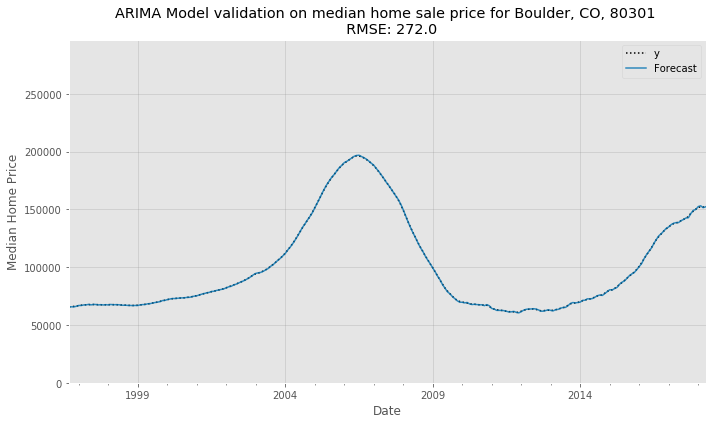

In [151]:
plot_model_validation(pred, pred_conf, df_zip, df, 80301)

In [17]:
def ARIMA_rmse(predicted_values, observed_values_df):
    """
    calculates the rmse for the ARIMA model
    """
    # Get the Real and predicted values
    zip_forecasted_array = predicted_values.predicted_mean
    zip_truth = observed_values_df[get_forecast_startdate(observed_values_df):]['y']

    # Compute the mean square error
    rmse = np.sqrt(((zip_forecasted_array - zip_truth)**2).mean())
    print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))
    return rmse
    

In [18]:
ARIMA_rmse(pred, df_zip)

The Root Mean Squared Error of our forecasts is 271.78


271.7783960280409

## Producing and Visualizing Forecasts

We will now describe how to leverage our seasonal ARIMA time series model to forecast future values. 

In [158]:
def ARIMA_forecast(observed_df, df_original, ARIMA_model, steps):
#     start_date = get_forecast_startdate(observed_df)
#     pred = ARIMA_model.get_prediction(start=pd.to_datetime(start_date),  dynamic=False)
#     pred_conf = ARIMA_model.conf_int()

    figsize=(10, 6)
    
    fig = plt.figure(figsize= figsize , facecolor='w')
    ax = fig.add_subplot(111)
    
    prediction = ARIMA_model.get_forecast(steps=steps, dynamic=False)

    # Get confidence intervals of forecasts
    pred_conf = prediction.conf_int()
    
    #get confidence intervals for historic forecast
    pred, pred_conf_hist = ARIMA_predictions(df_zip, ARIMA_model)
    
   
    
    #plot forecast
    
    observed_df.plot(ax = ax, label='Observed', ls='dotted', c='black')
    prediction.predicted_mean.plot(ax=ax, label='Forecast', c ='#0072B2' )
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='#0072B2', alpha=.25)
    
     # Plot the range for confidence intervals
    ax.fill_between(pred_conf_hist.index,
                    pred_conf_hist.iloc[:, 0],
                    pred_conf_hist.iloc[:, 1], color='#0072B2', alpha=.2)
    
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Median Home Value')
    plt.xlim(right=prediction.predicted_mean.index[-1])
    plt.ylim(bottom = 0,
            top = prediction.predicted_mean.max()+100000)

    ax.legend()
    
    #get values for Title
    city = list(df_original[df_original['RegionName'] == zipcode]['City'])[0]
    state = list(df_original[df_original['RegionName'] == zipcode]['State'])[0]
    
    
    plt.title(f"ARIMA Model Forecast \n Median Home sale price for {city}, {state}, {zipcode})")
    fig.tight_layout()
    plt.savefig(f'../../figures/{city}_ARIMA_model_forecast.png')
    
    plt.show()

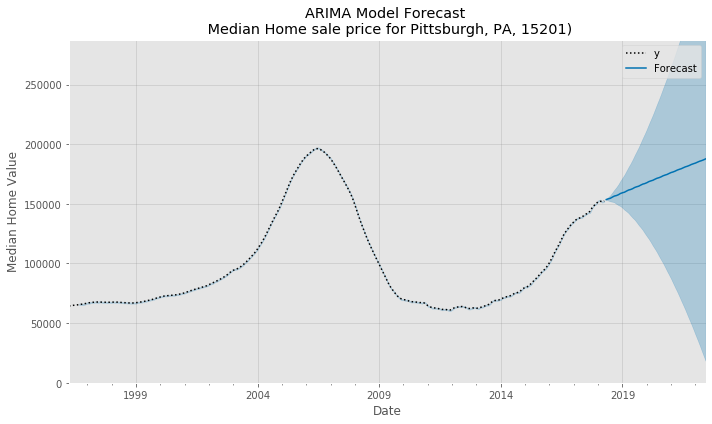

In [159]:
ARIMA_forecast(df_zip,df, output, 50)

### Pipline all of the above


In [54]:
def ARIMA_Analysis(df, zipcode, param_combos, forecast_steps):
    
    df_zip = prep_zip_for_ARIMA(df, zipcode)
    
    combo = ARIMA_param_gridsearch(df_zip, get_param_combos(param_combos))
    
    output = ARIMA_MODEL(df_zip, combo)
    
    pred, pred_conf = ARIMA_predictions(df_zip, output)
    
    plot_model_validation(pred, pred_conf, df_zip)
    
    ARIMA_rmse(pred, df_zip)
    
    ARIMA_forecast(df_zip, output, forecast_steps)
    

### Run the ARIMA analysis for our top 5 zipcodes

From our precious analysis using Facebook Prophet (see other notebook) we have determined the followin 5 zip codes 
are worthy of further exploration. 

[34982, 33982, 34951, 37209, 15201]


In [59]:
zipcodes = [34982, 33982, 34951, 37209, 15201]

/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) : AIC Calculated =6867.986508733736
ARIMA (0, 0, 1) : AIC Calculated =12774.799643436323


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 2) : AIC Calculated =6533.073548811351
ARIMA (0, 0, 3) : AIC Calculated =8307.754655571858


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 4) : AIC Calculated =7652.546447384641


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (0, 0, 5) : AIC Calculated =7248.374451393656
ARIMA (0, 1, 0) : AIC Calculated =4720.640987812769
ARIMA (0, 1, 1) : AIC Calculated =4361.456573244114
ARIMA (0, 1, 2) : AIC Calculated =4095.9445126862433


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 3) : AIC Calculated =3941.753971983573


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 4) : AIC Calculated =3891.855714339726


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (0, 1, 5) : AIC Calculated =3847.0370191139154
ARIMA (0, 2, 0) : AIC Calculated =3761.2093269636357
ARIMA (0, 2, 1) : AIC Calculated =3689.008230522384
ARIMA (0, 2, 2) : AIC Calculated =3674.353961656657
ARIMA (0, 2, 3) : AIC Calculated =3656.4220405286064
ARIMA (0, 2, 4) : AIC Calculated =3638.2637850600017
ARIMA (0, 2, 5) : AIC Calculated =3624.758117895597
ARIMA (0, 3, 0) : AIC Calculated =3819.3993941906656
ARIMA (0, 3, 1) : AIC Calculated =3770.3471931559616


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 3, 2) : AIC Calculated =3670.528280582548


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 3, 3) : AIC Calculated =3655.516135301209
ARIMA (0, 3, 4) : AIC Calculated =3632.9192157361044


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 3, 5) : AIC Calculated =3618.696150142079
ARIMA (0, 4, 0) : AIC Calculated =4004.5272920297634
ARIMA (0, 4, 1) : AIC Calculated =3829.582363934281


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 4, 2) : AIC Calculated =3833.2007592502478
ARIMA (0, 4, 3) : AIC Calculated =3697.694731825566


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 4, 4) : AIC Calculated =3671.052881413576


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 4, 5) : AIC Calculated =3657.2613936755424
ARIMA (0, 5, 0) : AIC Calculated =4239.448000914923
ARIMA (0, 5, 1) : AIC Calculated =3983.496394780203


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 5, 2) : AIC Calculated =3845.0899361420516
ARIMA (0, 5, 3) : AIC Calculated =3866.5203627851656


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 5, 4) : AIC Calculated =3774.9717536622557


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (0, 5, 5) : AIC Calculated =3760.7604360177925
ARIMA (1, 0, 0) : AIC Calculated =4731.94474097475
ARIMA (1, 0, 1) : AIC Calculated =4518.039961728465
ARIMA (1, 0, 2) : AIC Calculated =4107.6875486030585


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 3) : AIC Calculated =4335.346166862335


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 4) : AIC Calculated =4382.70855742136


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 5) : AIC Calculated =4368.147062645037
ARIMA (1, 1, 0) : AIC Calculated =3774.8913709547787
ARIMA (1, 1, 1) : AIC Calculated =3703.496310525852
ARIMA (1, 1, 2) : AIC Calculated =3686.932748628898


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 3) : AIC Calculated =3669.5902364326093
ARIMA (1, 1, 4) : AIC Calculated =3650.461705735601


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 5) : AIC Calculated =3636.73666002848
ARIMA (1, 2, 0) : AIC Calculated =3732.307214579522
ARIMA (1, 2, 1) : AIC Calculated =3687.90888126692
ARIMA (1, 2, 2) : AIC Calculated =3676.1500419908825


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 3) : AIC Calculated =3655.8366948502808


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 4) : AIC Calculated =3639.081169593167


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 5) : AIC Calculated =3626.661957876002
ARIMA (1, 3, 0) : AIC Calculated =3818.6866308810995
ARIMA (1, 3, 1) : AIC Calculated =3718.618268363522


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 3, 2) : AIC Calculated =3669.9718801560557


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 3, 3) : AIC Calculated =3658.382474038336
ARIMA (1, 3, 4) : AIC Calculated =3634.063315477921


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 3, 5) : AIC Calculated =3619.080823755881
ARIMA (1, 4, 0) : AIC Calculated =3979.940797072775
ARIMA (1, 4, 1) : AIC Calculated =3826.070601486267
ARIMA (1, 4, 2) : AIC Calculated =3821.3837801483733


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 4, 3) : AIC Calculated =3695.256178722168


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 4, 4) : AIC Calculated =3667.2350147822044
ARIMA (1, 4, 5) : AIC Calculated =3658.146084439057
ARIMA (1, 5, 0) : AIC Calculated =4174.491563758846
ARIMA (1, 5, 1) : AIC Calculated =3960.912509027298


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 5, 2) : AIC Calculated =3807.5374801534435


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 5, 3) : AIC Calculated =3823.9219054685996


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 5, 4) : AIC Calculated =3754.4724432058856


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmo

ARIMA (1, 5, 5) : AIC Calculated =3756.655342938984
ARIMA (2, 0, 0) : AIC Calculated =3774.9832142932737
ARIMA (2, 0, 1) : AIC Calculated =3761.319308045785


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 2) : AIC Calculated =3702.999207450971
ARIMA (2, 0, 3) : AIC Calculated =3687.7993225144796


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 4) : AIC Calculated =3669.6584274376946


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 5) : AIC Calculated =3652.7558220499586
ARIMA (2, 1, 0) : AIC Calculated =3730.7441095826243
ARIMA (2, 1, 1) : AIC Calculated =3700.112232656249
ARIMA (2, 1, 2) : AIC Calculated =3688.891888017126


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 3) : AIC Calculated =3668.898439391325


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 4) : AIC Calculated =3646.664881262992


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 5) : AIC Calculated =3634.797741505025
ARIMA (2, 2, 0) : AIC Calculated =3690.5264267799844
ARIMA (2, 2, 1) : AIC Calculated =3688.9072534572006
ARIMA (2, 2, 2) : AIC Calculated =3670.31030635671


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 3) : AIC Calculated =3650.19215894902


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 4) : AIC Calculated =3637.187846408389


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 5) : AIC Calculated =3621.9831328168493
ARIMA (2, 3, 0) : AIC Calculated =3713.38738508552
ARIMA (2, 3, 1) : AIC Calculated =3707.6498727761546


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 3, 2) : AIC Calculated =3665.92569478946


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 3, 3) : AIC Calculated =3657.685690553865


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 3, 4) : AIC Calculated =3625.9688672664915


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 3, 5) : AIC Calculated =3614.6416498013914
ARIMA (2, 4, 0) : AIC Calculated =3868.2143809318277
ARIMA (2, 4, 1) : AIC Calculated =3762.6881010736233


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 4, 2) : AIC Calculated =3726.4472459215754


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 4, 3) : AIC Calculated =3654.4451734117592


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 4, 4) : AIC Calculated =3650.8270427346442


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 4, 5) : AIC Calculated =3633.092067836726
ARIMA (2, 5, 0) : AIC Calculated =4062.0099613345647
ARIMA (2, 5, 1) : AIC Calculated =3861.668559951873


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 5, 2) : AIC Calculated =3740.7465218093844


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 5, 3) : AIC Calculated =3773.683643888764


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 5, 4) : AIC Calculated =3704.9878175578383


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 5, 5) : AIC Calculated =3709.5533555810466
ARIMA (3, 0, 0) : AIC Calculated =3732.2276004756277
ARIMA (3, 0, 1) : AIC Calculated =3703.7061408908708


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmo

ARIMA (3, 0, 2) : AIC Calculated =3710.219767205485
ARIMA (3, 0, 3) : AIC Calculated =3689.692012126936


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 0, 4) : AIC Calculated =3675.167775319378


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 0, 5) : AIC Calculated =3659.3817194992016
ARIMA (3, 1, 0) : AIC Calculated =3690.7709386846627
ARIMA (3, 1, 1) : AIC Calculated =3688.947602850443
ARIMA (3, 1, 2) : AIC Calculated =3690.7351299836223


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 3) : AIC Calculated =3659.381865261374


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 4) : AIC Calculated =3649.8182868797016


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (3, 1, 5) : AIC Calculated =3640.809027982029
ARIMA (3, 2, 0) : AIC Calculated =3661.7449726227815
ARIMA (3, 2, 1) : AIC Calculated =3663.453363346621
ARIMA (3, 2, 2) : AIC Calculated =3665.2857156178898
ARIMA (3, 2, 3) : AIC Calculated =3653.5126869932083


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 4) : AIC Calculated =3636.66242336863


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 5) : AIC Calculated =3634.346476380535
ARIMA (3, 3, 0) : AIC Calculated =3688.10401824667
ARIMA (3, 3, 1) : AIC Calculated =3656.28074226483


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 3, 2) : AIC Calculated =3658.278703408905


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 3, 3) : AIC Calculated =3645.5714564023633


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 3, 4) : AIC Calculated =3628.9473275592127


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 3, 5) : AIC Calculated =3630.244411243232
ARIMA (3, 4, 0) : AIC Calculated =3799.9469837831507
ARIMA (3, 4, 1) : AIC Calculated =3740.5416312162342


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 4, 2) : AIC Calculated =3742.116025938887


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 4, 3) : AIC Calculated =3656.6135135810086


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 4, 4) : AIC Calculated =3653.07740001886


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 4, 5) : AIC Calculated =3630.9824951150113
ARIMA (3, 5, 0) : AIC Calculated =3957.539500677365
ARIMA (3, 5, 1) : AIC Calculated =3800.157048001192


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 5, 2) : AIC Calculated =3754.713212431867


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 5, 3) : AIC Calculated =3748.6267064950857


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 5, 4) : AIC Calculated =3709.1180717992197


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 5, 5) : AIC Calculated =3722.9508340244397
ARIMA (4, 0, 0) : AIC Calculated =3691.203965614214


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 0, 1) : AIC Calculated =3709.3744673521132
ARIMA (4, 0, 2) : AIC Calculated =3691.703031940615


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 0, 3) : AIC Calculated =3689.914349202861


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 0, 4) : AIC Calculated =3674.7795902039466


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 0, 5) : AIC Calculated =3661.449453999786
ARIMA (4, 1, 0) : AIC Calculated =3660.6005764059337
ARIMA (4, 1, 1) : AIC Calculated =3662.2101828801574
ARIMA (4, 1, 2) : AIC Calculated =3663.901294909306


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 1, 3) : AIC Calculated =3674.0564576989173


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 1, 4) : AIC Calculated =3644.5541085946425
ARIMA (4, 1, 5) : AIC Calculated =3636.7655759262825
ARIMA (4, 2, 0) : AIC Calculated =3649.9658871740453
ARIMA (4, 2, 1) : AIC Calculated =3651.693966824964


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (4, 2, 2) : AIC Calculated =3663.102875402782
ARIMA (4, 2, 3) : AIC Calculated =3655.2061546082555


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 2, 4) : AIC Calculated =3643.135057197148


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 2, 5) : AIC Calculated =3626.4181524261403
ARIMA (4, 3, 0) : AIC Calculated =3671.774949766621
ARIMA (4, 3, 1) : AIC Calculated =3643.0544455593194


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 3, 2) : AIC Calculated =3644.642244483446


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 3, 3) : AIC Calculated =3646.7780614450962


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 3, 4) : AIC Calculated =3630.6729966944513


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 3, 5) : AIC Calculated =3620.3018881125863
ARIMA (4, 4, 0) : AIC Calculated =3769.1582577867566
ARIMA (4, 4, 1) : AIC Calculated =3706.7227598171903


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 4, 2) : AIC Calculated =3736.1061711415723


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 4, 3) : AIC Calculated =3654.5190677683477


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 4, 4) : AIC Calculated =3647.1373031733606


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 4, 5) : AIC Calculated =3628.0632028372193
ARIMA (4, 5, 0) : AIC Calculated =3900.768870293222
ARIMA (4, 5, 1) : AIC Calculated =3776.360771106839


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 5, 2) : AIC Calculated =3785.843634172479


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 5, 3) : AIC Calculated =3745.7046039707666


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 5, 4) : AIC Calculated =3719.009463170467


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 5, 5) : AIC Calculated =3708.962031470708
ARIMA (5, 0, 0) : AIC Calculated =3661.8250570920045


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 0, 1) : AIC Calculated =3697.9450739923823


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 0, 2) : AIC Calculated =3671.8677359036387
ARIMA (5, 0, 3) : AIC Calculated =3706.3807250726136


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 0, 4) : AIC Calculated =3686.7999791888005


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 0, 5) : AIC Calculated =3685.7762374263407
ARIMA (5, 1, 0) : AIC Calculated =3648.4388903928207
ARIMA (5, 1, 1) : AIC Calculated =3650.202231991794


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 1, 2) : AIC Calculated =3650.049376752709


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 1, 3) : AIC Calculated =4319.255979907399


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 1, 4) : AIC Calculated =3669.7304467196354


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 1, 5) : AIC Calculated =3635.634131523555
ARIMA (5, 2, 0) : AIC Calculated =3638.6778351544126
ARIMA (5, 2, 1) : AIC Calculated =3640.5117285151027
ARIMA (5, 2, 2) : AIC Calculated =3642.3136795942787


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 2, 3) : AIC Calculated =3638.914135312012


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 2, 4) : AIC Calculated =3639.1849583108788


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 2, 5) : AIC Calculated =3626.8923926310545
ARIMA (5, 3, 0) : AIC Calculated =3646.9883890432493
ARIMA (5, 3, 1) : AIC Calculated =3648.9023426365056
ARIMA (5, 3, 2) : AIC Calculated =3634.393742666385


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 3, 3) : AIC Calculated =3635.85863025332


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 3, 4) : AIC Calculated =3627.019500280382


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 3, 5) : AIC Calculated =3621.1450972355997
ARIMA (5, 4, 0) : AIC Calculated =3725.784541623832
ARIMA (5, 4, 1) : AIC Calculated =3693.308678115952


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 4, 2) : AIC Calculated =3689.0745342886657


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 4, 3) : AIC Calculated =3642.3887000060504
ARIMA (5, 4, 4) : AIC Calculated =3695.870608591511


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 4, 5) : AIC Calculated =3624.902364978271
ARIMA (5, 5, 0) : AIC Calculated =3850.78179549387


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 5, 1) : AIC Calculated =3741.4892388054286


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 5, 2) : AIC Calculated =3712.9534730770874


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 5, 3) : AIC Calculated =3722.1679589517507


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 5, 4) : AIC Calculated =3707.192630815031


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 5, 5) : AIC Calculated =3718.6803354204235
pdq    (2, 3, 5)
aic      3614.64
Name: 95, dtype: object


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6061      0.008     73.169      0.000       0.590       0.622
ar.L2         -1.0045      0.012    -86.537      0.000      -1.027      -0.982
ma.L1         -1.1282      0.115     -9.796      0.000      -1.354      -0.902
ma.L2          0.7561      0.162      4.664      0.000       0.438       1.074
ma.L3         -0.0868      0.120     -0.725      0.468      -0.321       0.148
ma.L4         -0.5649      0.114     -4.965      0.000      -0.788      -0.342
ma.L5          0.0272      0.062      0.442      0.659      -0.093       0.148
sigma2      7.717e+04   1.16e+04      6.626      0.000    5.43e+04       1e+05


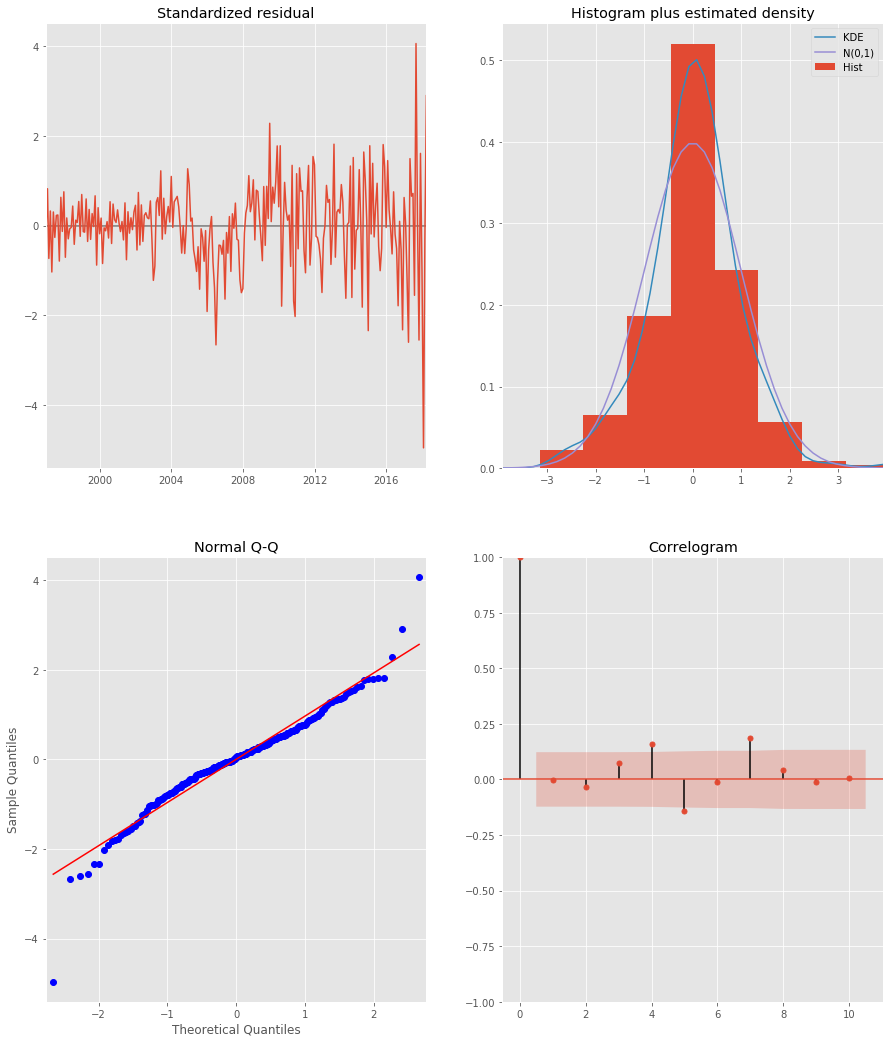

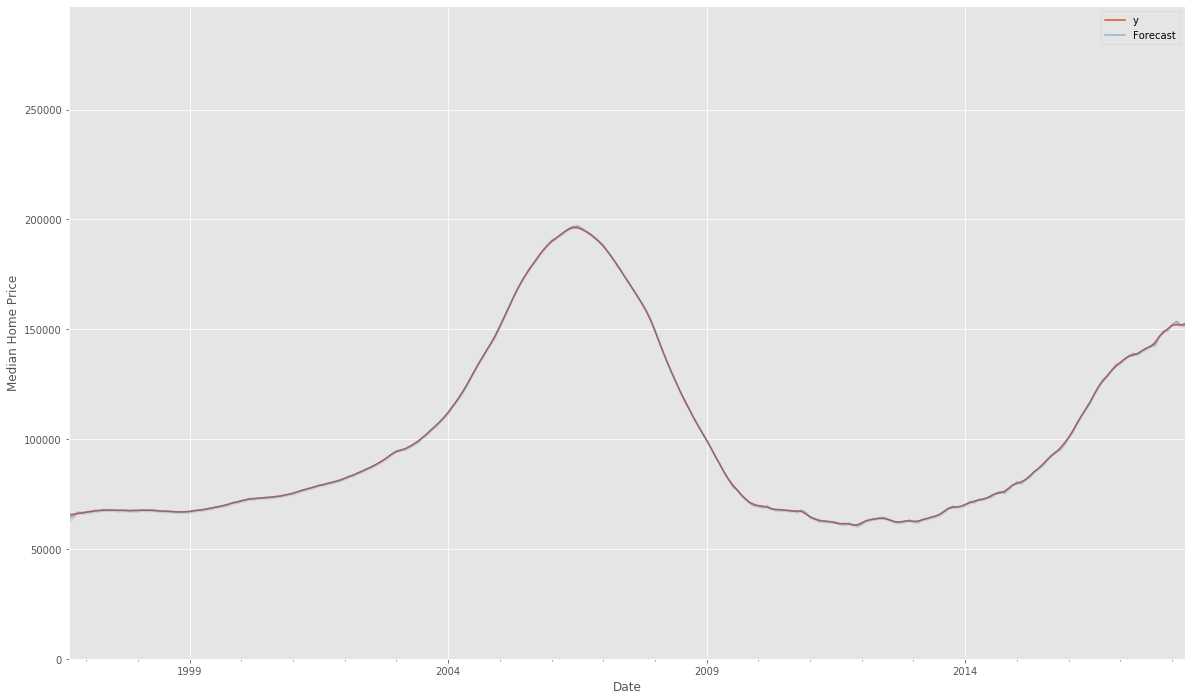

The Root Mean Squared Error of our forecasts is 280.58


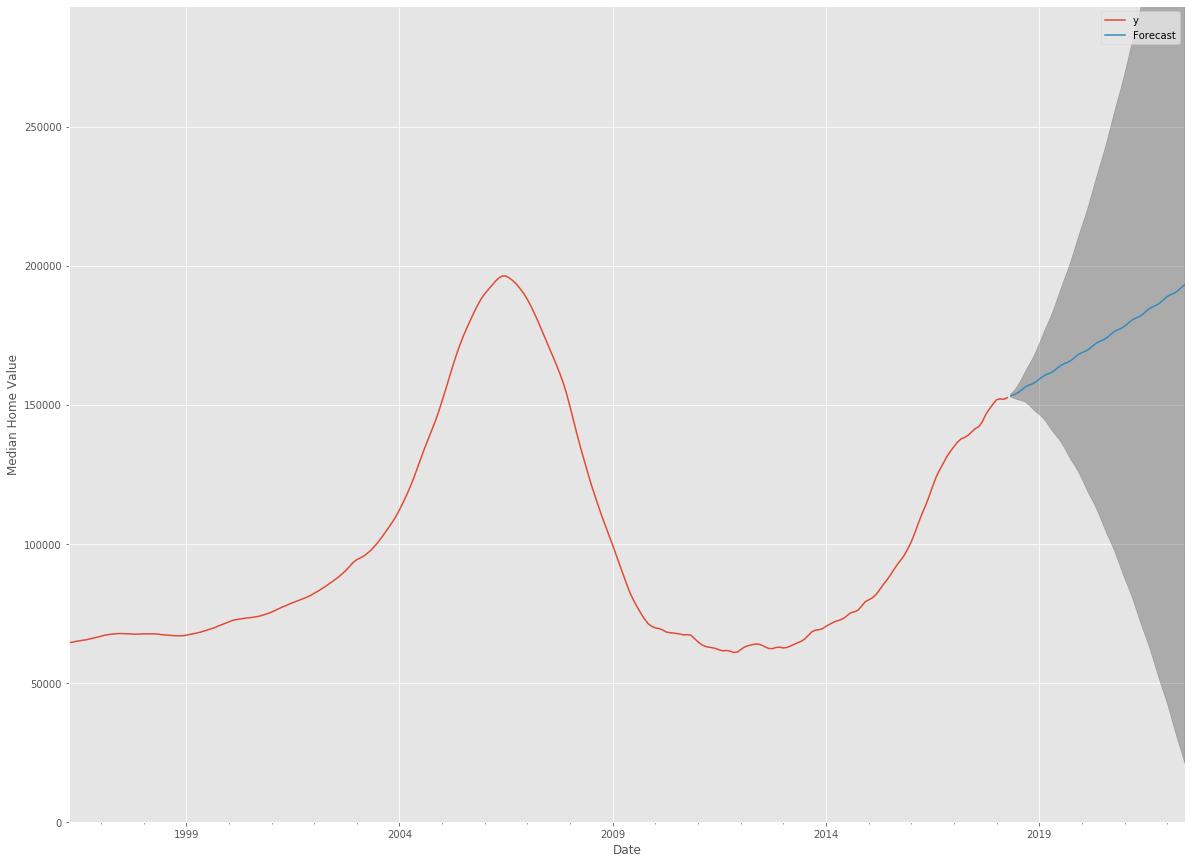

/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) : AIC Calculated =6978.424033244566
ARIMA (0, 0, 1) : AIC Calculated =6761.486106521377
ARIMA (0, 0, 2) : AIC Calculated =6694.101866756193
ARIMA (0, 0, 3) : AIC Calculated =8473.610646228051


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 4) : AIC Calculated =7807.194943485971


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (0, 0, 5) : AIC Calculated =7395.782891329924
ARIMA (0, 1, 0) : AIC Calculated =4865.078216163773
ARIMA (0, 1, 1) : AIC Calculated =4532.51565279279
ARIMA (0, 1, 2) : AIC Calculated =4247.760789229086


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 3) : AIC Calculated =4147.688567648447


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 4) : AIC Calculated =4082.8557899062325


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (0, 1, 5) : AIC Calculated =4063.7760908957225
ARIMA (0, 2, 0) : AIC Calculated =4219.66094121519
ARIMA (0, 2, 1) : AIC Calculated =4103.3383748356155
ARIMA (0, 2, 2) : AIC Calculated =4067.5300874164045
ARIMA (0, 2, 3) : AIC Calculated =4009.749996776706
ARIMA (0, 2, 4) : AIC Calculated =3984.041680964244


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 5) : AIC Calculated =3970.4565190071835
ARIMA (0, 3, 0) : AIC Calculated =4242.257395845994
ARIMA (0, 3, 1) : AIC Calculated =4210.32940528383


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 3, 2) : AIC Calculated =4074.761342702341
ARIMA (0, 3, 3) : AIC Calculated =4043.981078808488


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 3, 4) : AIC Calculated =3982.5455094865315
ARIMA (0, 3, 5) : AIC Calculated =3970.3425460467843


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 4, 0) : AIC Calculated =4377.348008399607
ARIMA (0, 4, 1) : AIC Calculated =4241.023849227437
ARIMA (0, 4, 2) : AIC Calculated =4200.566146079373


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 4, 3) : AIC Calculated =4066.036058951479


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 4, 4) : AIC Calculated =4038.6423041924836


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 4, 5) : AIC Calculated =3988.406833326455
ARIMA (0, 5, 0) : AIC Calculated =4570.9007553116035
ARIMA (0, 5, 1) : AIC Calculated =4363.44494782349


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 5, 2) : AIC Calculated =4201.385834403123
ARIMA (0, 5, 3) : AIC Calculated =4225.044406522481


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 5, 4) : AIC Calculated =4149.754629634166


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (0, 5, 5) : AIC Calculated =4073.486905912808
ARIMA (1, 0, 0) : AIC Calculated =4874.140859610119
ARIMA (1, 0, 1) : AIC Calculated =4641.233550472882
ARIMA (1, 0, 2) : AIC Calculated =4548.691820908527


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 3) : AIC Calculated =4173.394852132496
ARIMA (1, 0, 4) : AIC Calculated =4475.24875690029


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (1, 0, 5) : AIC Calculated =4441.335304643037
ARIMA (1, 1, 0) : AIC Calculated =4230.80214423944
ARIMA (1, 1, 1) : AIC Calculated =4114.561186485813
ARIMA (1, 1, 2) : AIC Calculated =4067.183315460269
ARIMA (1, 1, 3) : AIC Calculated =4022.2060520301397


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 4) : AIC Calculated =3996.6582496899746


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 5) : AIC Calculated =3982.9898694273134
ARIMA (1, 2, 0) : AIC Calculated =4171.206873750692
ARIMA (1, 2, 1) : AIC Calculated =4104.237756303081
ARIMA (1, 2, 2) : AIC Calculated =4082.467075280385


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 3) : AIC Calculated =4011.43498846768


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 4) : AIC Calculated =3985.5162410209155


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 5) : AIC Calculated =3973.0682099939504
ARIMA (1, 3, 0) : AIC Calculated =4241.161950773056
ARIMA (1, 3, 1) : AIC Calculated =4205.876044555729


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 3, 2) : AIC Calculated =4072.2412900129793


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 3, 3) : AIC Calculated =4027.245858607813


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 3, 4) : AIC Calculated =3982.422389671774


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 3, 5) : AIC Calculated =3968.129177407338
ARIMA (1, 4, 0) : AIC Calculated =4375.401057139247
ARIMA (1, 4, 1) : AIC Calculated =4217.480477701167
ARIMA (1, 4, 2) : AIC Calculated =4196.597046571645


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 4, 3) : AIC Calculated =4080.7342233592826


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 4, 4) : AIC Calculated =4021.8336032239868


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 4, 5) : AIC Calculated =3984.9049100086313
ARIMA (1, 5, 0) : AIC Calculated =4546.04724185273
ARIMA (1, 5, 1) : AIC Calculated =4352.884077735474


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 5, 2) : AIC Calculated =4342.944965796011


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 5, 3) : AIC Calculated =4215.664874989496


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 5, 4) : AIC Calculated =4156.809966263849


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (1, 5, 5) : AIC Calculated =4066.7476329047063
ARIMA (2, 0, 0) : AIC Calculated =4232.6798295884155
ARIMA (2, 0, 1) : AIC Calculated =4220.316934891195
ARIMA (2, 0, 2) : AIC Calculated =4093.07873958404


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 3) : AIC Calculated =4072.05940282662
ARIMA (2, 0, 4) : AIC Calculated =4021.034299384181
ARIMA (2, 0, 5) : AIC Calculated =4004.7532009916094


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) : AIC Calculated =4157.679486213729
ARIMA (2, 1, 1) : AIC Calculated =4114.8662574964865


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) : AIC Calculated =4067.8809834615386
ARIMA (2, 1, 3) : AIC Calculated =4021.0052804053284


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 4) : AIC Calculated =3998.619005216834


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (2, 1, 5) : AIC Calculated =3985.9960050622603
ARIMA (2, 2, 0) : AIC Calculated =4057.4043892912905
ARIMA (2, 2, 1) : AIC Calculated =4057.5401614490897
ARIMA (2, 2, 2) : AIC Calculated =4040.043313429686
ARIMA (2, 2, 3) : AIC Calculated =4010.4297395650538


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 4) : AIC Calculated =3987.477055571261


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (2, 2, 5) : AIC Calculated =3978.2693696086167
ARIMA (2, 3, 0) : AIC Calculated =4119.608483137396
ARIMA (2, 3, 1) : AIC Calculated =4095.9754981786527
ARIMA (2, 3, 2) : AIC Calculated =4033.615357043001


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 3, 3) : AIC Calculated =4017.4440488731743


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 3, 4) : AIC Calculated =3983.8166313929737


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 3, 5) : AIC Calculated =3972.896908706657
ARIMA (2, 4, 0) : AIC Calculated =4257.949778567578
ARIMA (2, 4, 1) : AIC Calculated =4117.921635453254
ARIMA (2, 4, 2) : AIC Calculated =4115.587973090869


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 4, 3) : AIC Calculated =4034.5227399937735


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 4, 4) : AIC Calculated =4022.190388753543


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 4, 5) : AIC Calculated =3985.3695821506703
ARIMA (2, 5, 0) : AIC Calculated =4440.868722922571
ARIMA (2, 5, 1) : AIC Calculated =4249.353191005028


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 5, 2) : AIC Calculated =4099.105425293756
ARIMA (2, 5, 3) : AIC Calculated =4131.290189037639


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 5, 4) : AIC Calculated =4077.5864816591693
ARIMA (2, 5, 5) : AIC Calculated =4061.439351211905
ARIMA (3, 0, 0) : AIC Calculated =4159.626118085344


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 0, 1) : AIC Calculated =4119.887391150721


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 0, 2) : AIC Calculated =4093.193306057159


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 0, 3) : AIC Calculated =4071.7092292571297
ARIMA (3, 0, 4) : AIC Calculated =4090.7233677510258


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (3, 0, 5) : AIC Calculated =4021.5152922254383
ARIMA (3, 1, 0) : AIC Calculated =4055.3254205450658
ARIMA (3, 1, 1) : AIC Calculated =4054.2330589814624
ARIMA (3, 1, 2) : AIC Calculated =4055.7951791376345


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 3) : AIC Calculated =4019.5799057085587


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 4) : AIC Calculated =4008.026444067633


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (3, 1, 5) : AIC Calculated =3986.7673594658218
ARIMA (3, 2, 0) : AIC Calculated =4039.567728156824
ARIMA (3, 2, 1) : AIC Calculated =4040.735370397367
ARIMA (3, 2, 2) : AIC Calculated =4042.7700879957974


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 3) : AIC Calculated =4008.644054325203
ARIMA (3, 2, 4) : AIC Calculated =3997.115980244832


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 5) : AIC Calculated =3979.104399710442
ARIMA (3, 3, 0) : AIC Calculated =4098.425662741963
ARIMA (3, 3, 1) : AIC Calculated =4032.3456296029526


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 3, 2) : AIC Calculated =4035.699425679311


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 3, 3) : AIC Calculated =4019.0950804724425


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 3, 4) : AIC Calculated =3985.7650690496266


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 3, 5) : AIC Calculated =3967.873616775303
ARIMA (3, 4, 0) : AIC Calculated =4200.295146838027
ARIMA (3, 4, 1) : AIC Calculated =4108.236117269536


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 4, 2) : AIC Calculated =4102.225351704682


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 4, 3) : AIC Calculated =4029.9133004264513
ARIMA (3, 4, 4) : AIC Calculated =4013.0874784681528


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 4, 5) : AIC Calculated =3985.7172618027225
ARIMA (3, 5, 0) : AIC Calculated =4327.478010015585
ARIMA (3, 5, 1) : AIC Calculated =4226.530037590232


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 5, 2) : AIC Calculated =4145.992285916298


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 5, 3) : AIC Calculated =4102.5174980414395


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 5, 4) : AIC Calculated =4068.8210368400732


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 5, 5) : AIC Calculated =4045.45287933762
ARIMA (4, 0, 0) : AIC Calculated =4057.142060946527
ARIMA (4, 0, 1) : AIC Calculated =4057.2426073147453


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 0, 2) : AIC Calculated =4059.985385722949


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 0, 3) : AIC Calculated =4058.8222712271845
ARIMA (4, 0, 4) : AIC Calculated =4078.8332292662535


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (4, 0, 5) : AIC Calculated =4046.658355939905
ARIMA (4, 1, 0) : AIC Calculated =4035.772743801638
ARIMA (4, 1, 1) : AIC Calculated =4036.8617245388286


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 1, 2) : AIC Calculated =4045.328162442937
ARIMA (4, 1, 3) : AIC Calculated =4019.712038543118


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 1, 4) : AIC Calculated =4008.620034684457


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 1, 5) : AIC Calculated =3996.2716978257945
ARIMA (4, 2, 0) : AIC Calculated =4022.809615083012
ARIMA (4, 2, 1) : AIC Calculated =4023.9600390627456


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 2, 2) : AIC Calculated =4047.318350335229


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 2, 3) : AIC Calculated =4003.8411621942864
ARIMA (4, 2, 4) : AIC Calculated =3988.907805018197


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 2, 5) : AIC Calculated =3988.1936601671623
ARIMA (4, 3, 0) : AIC Calculated =4078.90093120383
ARIMA (4, 3, 1) : AIC Calculated =4029.8150350131355


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 3, 2) : AIC Calculated =4022.139829164038


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 3, 3) : AIC Calculated =4013.748390971543


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 3, 4) : AIC Calculated =3985.122462796182


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 3, 5) : AIC Calculated =4004.9266592919394
ARIMA (4, 4, 0) : AIC Calculated =4182.5070444983685
ARIMA (4, 4, 1) : AIC Calculated =4076.904749621775


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 4, 2) : AIC Calculated =4083.3401498222925
ARIMA (4, 4, 3) : AIC Calculated =4079.990188873733


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 4, 4) : AIC Calculated =4014.7671829026804


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 4, 5) : AIC Calculated =3987.593677796056
ARIMA (4, 5, 0) : AIC Calculated =4303.1901829258295
ARIMA (4, 5, 1) : AIC Calculated =4173.131124703617


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 5, 2) : AIC Calculated =4184.657523678658


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 5, 3) : AIC Calculated =4102.549261609906


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 5, 4) : AIC Calculated =4064.58456756011


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 5, 5) : AIC Calculated =4041.5741022530433
ARIMA (5, 0, 0) : AIC Calculated =4037.7055005096963
ARIMA (5, 0, 1) : AIC Calculated =4098.28102756305


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 0, 2) : AIC Calculated =4096.973282821635


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 0, 3) : AIC Calculated =4315.440447419111


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 0, 4) : AIC Calculated =4061.34809539358


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 0, 5) : AIC Calculated =4038.200906840589
ARIMA (5, 1, 0) : AIC Calculated =4020.3004837218314
ARIMA (5, 1, 1) : AIC Calculated =4043.7588166029245


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 1, 2) : AIC Calculated =4001.058300839227


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 1, 3) : AIC Calculated =4000.159087086131


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 1, 4) : AIC Calculated =4001.4830352151157


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (5, 1, 5) : AIC Calculated =3995.7556136794974
ARIMA (5, 2, 0) : AIC Calculated =4005.5747187002344
ARIMA (5, 2, 1) : AIC Calculated =4006.3204381180863


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 2, 2) : AIC Calculated =3999.9087152921084
ARIMA (5, 2, 3) : AIC Calculated =3988.8855714818783


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 2, 4) : AIC Calculated =3990.23283404056


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 2, 5) : AIC Calculated =3983.865133688748
ARIMA (5, 3, 0) : AIC Calculated =4018.836205192787
ARIMA (5, 3, 1) : AIC Calculated =4020.375335771526
ARIMA (5, 3, 2) : AIC Calculated =3998.163199676869


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 3, 3) : AIC Calculated =3996.880871010876


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 3, 4) : AIC Calculated =3987.3744256566492


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 3, 5) : AIC Calculated =3970.0954847448747
ARIMA (5, 4, 0) : AIC Calculated =4111.3515554103415
ARIMA (5, 4, 1) : AIC Calculated =4032.6919186510486


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 4, 2) : AIC Calculated =4031.7856072485347


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 4, 3) : AIC Calculated =4014.68874144038
ARIMA (5, 4, 4) : AIC Calculated =4016.3301515146572


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 4, 5) : AIC Calculated =3987.731107241524
ARIMA (5, 5, 0) : AIC Calculated =4224.854684486629
ARIMA (5, 5, 1) : AIC Calculated =4102.366444250574


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 5, 2) : AIC Calculated =4086.554179783698


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 5, 3) : AIC Calculated =4059.9178017115946


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 5, 4) : AIC Calculated =4036.244709603247


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 5, 5) : AIC Calculated =4029.359178616756
pdq    (3, 3, 5)
aic      3967.87
Name: 131, dtype: object


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3569      0.338     -1.055      0.292      -1.020       0.306
ar.L2          0.0083      0.149      0.056      0.956      -0.283       0.300
ar.L3         -0.1808      0.139     -1.300      0.194      -0.453       0.092
ma.L1          0.2119      0.387      0.547      0.584      -0.548       0.971
ma.L2         -1.0353      0.228     -4.546      0.000      -1.482      -0.589
ma.L3         -0.6332      0.349     -1.815      0.070      -1.317       0.051
ma.L4          0.3233      0.185      1.745      0.081      -0.040       0.686
ma.L5          0.1353      0.217      0.623      0.533      -0.290       0.561
sigma2      3.361e+05   6.59e+04      5.100      0.000    2.07e+05    4.65e+05


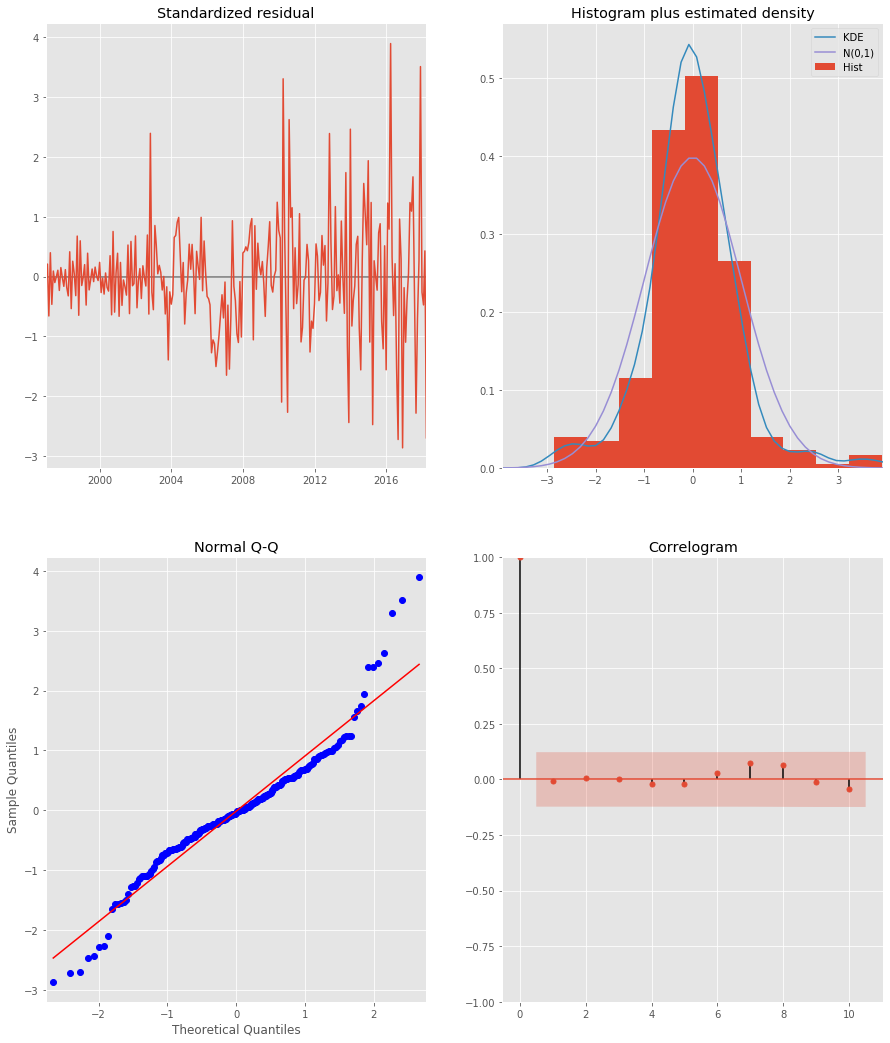

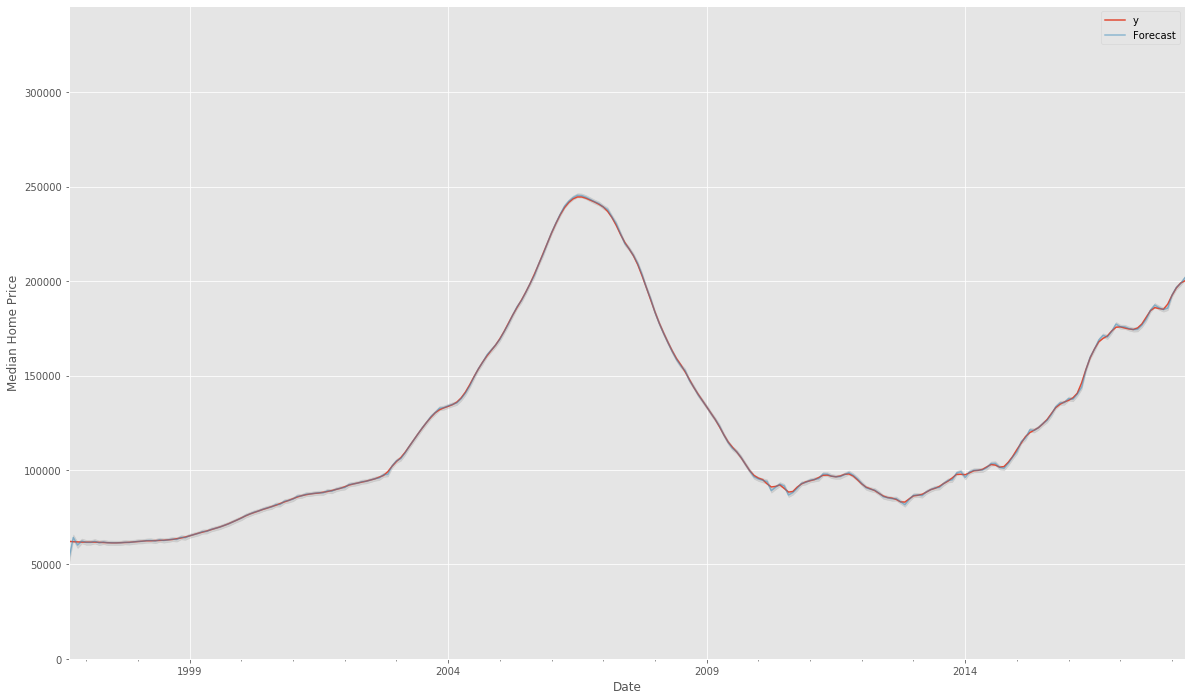

The Root Mean Squared Error of our forecasts is 804.11


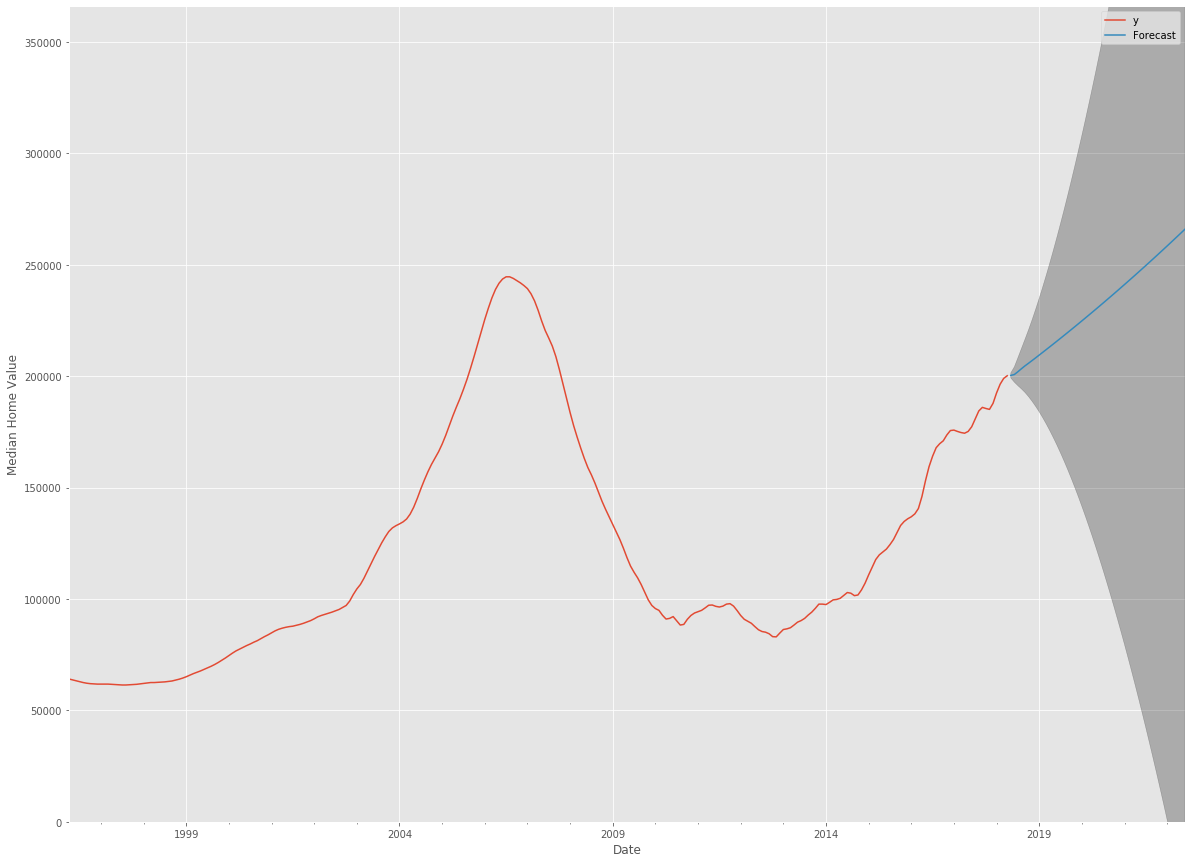

/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) : AIC Calculated =6885.740432160234
ARIMA (0, 0, 1) : AIC Calculated =6669.550864300221
ARIMA (0, 0, 2) : AIC Calculated =6602.150671154229
ARIMA (0, 0, 3) : AIC Calculated =6567.445988594165


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 4) : AIC Calculated =7698.475527445655


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (0, 0, 5) : AIC Calculated =7340.526026030388
ARIMA (0, 1, 0) : AIC Calculated =4706.102201464776
ARIMA (0, 1, 1) : AIC Calculated =4361.56547869148
ARIMA (0, 1, 2) : AIC Calculated =4086.7393598158997


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 3) : AIC Calculated =3975.9024835457644


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 4) : AIC Calculated =3869.78925798702


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (0, 1, 5) : AIC Calculated =3851.6554910315353
ARIMA (0, 2, 0) : AIC Calculated =3834.39207652274
ARIMA (0, 2, 1) : AIC Calculated =3754.136853905972
ARIMA (0, 2, 2) : AIC Calculated =3741.8118287215693
ARIMA (0, 2, 3) : AIC Calculated =3716.071001574381
ARIMA (0, 2, 4) : AIC Calculated =3697.2270243984995


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 5) : AIC Calculated =3682.6531589592596
ARIMA (0, 3, 0) : AIC Calculated =3867.0865534997283
ARIMA (0, 3, 1) : AIC Calculated =3843.1857823053233
ARIMA (0, 3, 2) : AIC Calculated =3736.5155917787033


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 3, 3) : AIC Calculated =3721.928135639697


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 3, 4) : AIC Calculated =3694.261906645578


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 3, 5) : AIC Calculated =3676.6620563534316
ARIMA (0, 4, 0) : AIC Calculated =4051.4196959134233
ARIMA (0, 4, 1) : AIC Calculated =3877.990714589567
ARIMA (0, 4, 2) : AIC Calculated =3890.6803783152905


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 4, 3) : AIC Calculated =3759.2534846993703


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 4, 4) : AIC Calculated =3733.241633576299


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 4, 5) : AIC Calculated =3691.3267812041395
ARIMA (0, 5, 0) : AIC Calculated =4291.371739254981
ARIMA (0, 5, 1) : AIC Calculated =4028.3486338295597


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 5, 2) : AIC Calculated =3848.389729115229
ARIMA (0, 5, 3) : AIC Calculated =3939.129341216737


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 5, 4) : AIC Calculated =3787.183043715886
ARIMA (0, 5, 5) : AIC Calculated =3778.0053497398444
ARIMA (1, 0, 0) : AIC Calculated =4717.70851748602
ARIMA (1, 0, 1) : AIC Calculated =4502.865657971079


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 2) : AIC Calculated =4098.568192977291


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 3) : AIC Calculated =3991.579127851215


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 4) : AIC Calculated =4274.270855729155


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (1, 0, 5) : AIC Calculated =4289.5398781456925
ARIMA (1, 1, 0) : AIC Calculated =3847.6776789073574
ARIMA (1, 1, 1) : AIC Calculated =3766.9020402779247
ARIMA (1, 1, 2) : AIC Calculated =3752.3926525183715
ARIMA (1, 1, 3) : AIC Calculated =3729.4482034389966


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 4) : AIC Calculated =3709.1121959414263
ARIMA (1, 1, 5) : AIC Calculated =3694.8034653460754
ARIMA (1, 2, 0) : AIC Calculated =3790.3484519945746
ARIMA (1, 2, 1) : AIC Calculated =3756.1358078874023
ARIMA (1, 2, 2) : AIC Calculated =3742.638967556046


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 3) : AIC Calculated =3707.420571635696


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 4) : AIC Calculated =3696.748194761621


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 5) : AIC Calculated =3684.4044100901856
ARIMA (1, 3, 0) : AIC Calculated =3867.5575311580724
ARIMA (1, 3, 1) : AIC Calculated =3775.730875964138


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 3, 2) : AIC Calculated =3734.5987913453637


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 3, 3) : AIC Calculated =3709.4457061581575


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 3, 4) : AIC Calculated =3690.787381969991


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (1, 3, 5) : AIC Calculated =3675.1518666442435
ARIMA (1, 4, 0) : AIC Calculated =4021.5362550262616
ARIMA (1, 4, 1) : AIC Calculated =3875.2247229550676
ARIMA (1, 4, 2) : AIC Calculated =3876.4292119173656
ARIMA (1, 4, 3) : AIC Calculated =3735.7885498360383


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 4, 4) : AIC Calculated =3717.4748047146904


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (1, 4, 5) : AIC Calculated =3690.2821713058074
ARIMA (1, 5, 0) : AIC Calculated =4214.132383053142
ARIMA (1, 5, 1) : AIC Calculated =4002.098936721867
ARIMA (1, 5, 2) : AIC Calculated =3895.975927931827


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 5, 3) : AIC Calculated =3887.1381247355594


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 5, 4) : AIC Calculated =3801.2683090525


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 5, 5) : AIC Calculated =3758.780712589777
ARIMA (2, 0, 0) : AIC Calculated =3848.82409819328


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (2, 0, 1) : AIC Calculated =3827.9635600074635
ARIMA (2, 0, 2) : AIC Calculated =3768.3997152172387
ARIMA (2, 0, 3) : AIC Calculated =3753.5343502060496


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 4) : AIC Calculated =3731.054617866023


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 5) : AIC Calculated =3713.4938168171675
ARIMA (2, 1, 0) : AIC Calculated =3786.5307655318284
ARIMA (2, 1, 1) : AIC Calculated =3768.0774323774986


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) : AIC Calculated =3754.2397986466967
ARIMA (2, 1, 3) : AIC Calculated =3719.9524118760683


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 4) : AIC Calculated =3713.82616021603
ARIMA (2, 1, 5) : AIC Calculated =3695.5503858633538
ARIMA (2, 2, 0) : AIC Calculated =3751.5841418307236
ARIMA (2, 2, 1) : AIC Calculated =3752.4810666665917
ARIMA (2, 2, 2) : AIC Calculated =3739.0585328327343


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 3) : AIC Calculated =3709.139784240034


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 4) : AIC Calculated =3697.6974197846125


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 5) : AIC Calculated =3686.767257576054
ARIMA (2, 3, 0) : AIC Calculated =3803.415755123124


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 3, 1) : AIC Calculated =3766.2863957902123


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 3, 2) : AIC Calculated =3730.183403715094


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 3, 3) : AIC Calculated =3708.579945038336


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 3, 4) : AIC Calculated =3691.3085476190454


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 3, 5) : AIC Calculated =3676.973399591244
ARIMA (2, 4, 0) : AIC Calculated =3940.620074361956
ARIMA (2, 4, 1) : AIC Calculated =3844.557463673378


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 4, 2) : AIC Calculated =3798.871325486375


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 4, 3) : AIC Calculated =3723.075728244253
ARIMA (2, 4, 4) : AIC Calculated =3713.415270832951


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 4, 5) : AIC Calculated =3689.972017785213
ARIMA (2, 5, 0) : AIC Calculated =4119.9720483558685
ARIMA (2, 5, 1) : AIC Calculated =3932.8577268784247


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 5, 2) : AIC Calculated =3864.0452616376597


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 5, 3) : AIC Calculated =3867.164977756902


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 5, 4) : AIC Calculated =3815.3894501934446


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmo

ARIMA (2, 5, 5) : AIC Calculated =3749.6967232665365
ARIMA (3, 0, 0) : AIC Calculated =3788.447834928399
ARIMA (3, 0, 1) : AIC Calculated =3770.0199860123776


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 0, 2) : AIC Calculated =3774.7387974378266


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 0, 3) : AIC Calculated =3741.1152001960704
ARIMA (3, 0, 4) : AIC Calculated =3901.4386309084293


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 0, 5) : AIC Calculated =3720.9053036922255
ARIMA (3, 1, 0) : AIC Calculated =3750.5808132125812
ARIMA (3, 1, 1) : AIC Calculated =3753.678041403303
ARIMA (3, 1, 2) : AIC Calculated =3737.64330094635
ARIMA (3, 1, 3) : AIC Calculated =3722.2969378157954


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 4) : AIC Calculated =3713.9478954060764


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (3, 1, 5) : AIC Calculated =3698.852261032543
ARIMA (3, 2, 0) : AIC Calculated =3737.502707506739
ARIMA (3, 2, 1) : AIC Calculated =3739.127442728615


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 2) : AIC Calculated =3755.576513325842
ARIMA (3, 2, 3) : AIC Calculated =3711.955156759467


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 4) : AIC Calculated =3687.683377017276


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 5) : AIC Calculated =3679.909082635199
ARIMA (3, 3, 0) : AIC Calculated =3779.723217997814
ARIMA (3, 3, 1) : AIC Calculated =3730.509584275462


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 3, 2) : AIC Calculated =3731.959801195032
ARIMA (3, 3, 3) : AIC Calculated =3710.532580841269


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 3, 4) : AIC Calculated =3689.952792148572


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 3, 5) : AIC Calculated =3673.5956718213256
ARIMA (3, 4, 0) : AIC Calculated =3884.0823082432653
ARIMA (3, 4, 1) : AIC Calculated =3824.6775234247457


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 4, 2) : AIC Calculated =3824.1588926280565


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 4, 3) : AIC Calculated =3723.915196881111
ARIMA (3, 4, 4) : AIC Calculated =3713.4447063387097


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 4, 5) : AIC Calculated =3691.19845374952
ARIMA (3, 5, 0) : AIC Calculated =4018.619012670088
ARIMA (3, 5, 1) : AIC Calculated =3879.036932452106


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 5, 2) : AIC Calculated =3842.2832187012623


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 5, 3) : AIC Calculated =3815.3130338547962
ARIMA (3, 5, 4) : AIC Calculated =3791.1434265367675


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmo

ARIMA (3, 5, 5) : AIC Calculated =3758.2564413201867
ARIMA (4, 0, 0) : AIC Calculated =3752.1048813930925


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 0, 1) : AIC Calculated =3797.408522299741
ARIMA (4, 0, 2) : AIC Calculated =3754.266775554509


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 0, 3) : AIC Calculated =4022.7794846725233
ARIMA (4, 0, 4) : AIC Calculated =3760.933668278505


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 0, 5) : AIC Calculated =3732.1495759525696
ARIMA (4, 1, 0) : AIC Calculated =3735.7738369639596
ARIMA (4, 1, 1) : AIC Calculated =3737.4848859524323


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 1, 2) : AIC Calculated =3722.478237472673


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 1, 3) : AIC Calculated =3723.7680953836666
ARIMA (4, 1, 4) : AIC Calculated =3705.3299793207802


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (4, 1, 5) : AIC Calculated =3703.969843487817
ARIMA (4, 2, 0) : AIC Calculated =3725.68254370856
ARIMA (4, 2, 1) : AIC Calculated =3727.683600222066


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 2, 2) : AIC Calculated =3737.0380344416917
ARIMA (4, 2, 3) : AIC Calculated =3718.5542814542378


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 2, 4) : AIC Calculated =3697.771732461202


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 2, 5) : AIC Calculated =3682.749645391158
ARIMA (4, 3, 0) : AIC Calculated =3763.219533241785
ARIMA (4, 3, 1) : AIC Calculated =3722.861609585044


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 3, 2) : AIC Calculated =3724.1423665906364


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 3, 3) : AIC Calculated =3711.9755393025293


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 3, 4) : AIC Calculated =3691.9392664051356


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 3, 5) : AIC Calculated =3687.4797982210675
ARIMA (4, 4, 0) : AIC Calculated =3865.514568757267
ARIMA (4, 4, 1) : AIC Calculated =3783.2658903339207


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 4, 2) : AIC Calculated =3826.1715685915515


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 4, 3) : AIC Calculated =3804.368698396619


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 4, 4) : AIC Calculated =3715.2677180117585


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 4, 5) : AIC Calculated =3689.947042982928
ARIMA (4, 5, 0) : AIC Calculated =3991.014094390812
ARIMA (4, 5, 1) : AIC Calculated =3863.5215978303604


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 5, 2) : AIC Calculated =3868.380069946493


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 5, 3) : AIC Calculated =3871.9619530987757
ARIMA (4, 5, 4) : AIC Calculated =3785.462354604856


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 5, 5) : AIC Calculated =3766.006906776773
ARIMA (5, 0, 0) : AIC Calculated =3737.4988193503677


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 0, 1) : AIC Calculated =3777.1229100831533
ARIMA (5, 0, 2) : AIC Calculated =3725.3747116405075


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 0, 3) : AIC Calculated =5000.462165423631


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 0, 4) : AIC Calculated =3951.582852615241


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 0, 5) : AIC Calculated =3751.2834652510483
ARIMA (5, 1, 0) : AIC Calculated =3724.1150303658574
ARIMA (5, 1, 1) : AIC Calculated =3726.1165064257216


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 1, 2) : AIC Calculated =3710.1967998090286


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 1, 3) : AIC Calculated =3709.965713031846


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 1, 4) : AIC Calculated =3707.3333166831735


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 1, 5) : AIC Calculated =3701.993993555509
ARIMA (5, 2, 0) : AIC Calculated =3712.9103306222582
ARIMA (5, 2, 1) : AIC Calculated =3714.4967290222016


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 2, 2) : AIC Calculated =3716.028483053551
ARIMA (5, 2, 3) : AIC Calculated =3702.053925307483


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 2, 4) : AIC Calculated =3699.007309728423


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 2, 5) : AIC Calculated =3687.4994605458496
ARIMA (5, 3, 0) : AIC Calculated =3714.302356929624
ARIMA (5, 3, 1) : AIC Calculated =3716.2769842442804
ARIMA (5, 3, 2) : AIC Calculated =3704.562793140212


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 3, 3) : AIC Calculated =3695.788265427006


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 3, 4) : AIC Calculated =3695.8964175779447


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 3, 5) : AIC Calculated =3689.8712623071397
ARIMA (5, 4, 0) : AIC Calculated =3809.5020344555555
ARIMA (5, 4, 1) : AIC Calculated =3754.921128586175


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 4, 2) : AIC Calculated =3752.7407495704974


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 4, 3) : AIC Calculated =3769.0008890528493


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 4, 4) : AIC Calculated =3711.0351169264823


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 4, 5) : AIC Calculated =3697.8582655748037
ARIMA (5, 5, 0) : AIC Calculated =3925.1375028741672
ARIMA (5, 5, 1) : AIC Calculated =3812.421375513809


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 5, 2) : AIC Calculated =3796.9136151330813
ARIMA (5, 5, 3) : AIC Calculated =3850.6005186438597


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 5, 4) : AIC Calculated =3773.151036729392


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 5, 5) : AIC Calculated =3741.8396900621306
pdq    (3, 3, 5)
aic       3673.6
Name: 131, dtype: object


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8352      0.100      8.366      0.000       0.640       1.031
ar.L2          0.2122      0.153      1.390      0.165      -0.087       0.511
ar.L3         -0.4944      0.097     -5.099      0.000      -0.684      -0.304
ma.L1         -1.2904      0.095    -13.620      0.000      -1.476      -1.105
ma.L2         -0.5119      0.155     -3.303      0.001      -0.816      -0.208
ma.L3          1.0334      0.127      8.151      0.000       0.785       1.282
ma.L4          0.4238      0.102      4.145      0.000       0.223       0.624
ma.L5         -0.6521      0.061    -10.635      0.000      -0.772      -0.532
sigma2      1.051e+05   8569.587     12.264      0.000    8.83e+04    1.22e+05


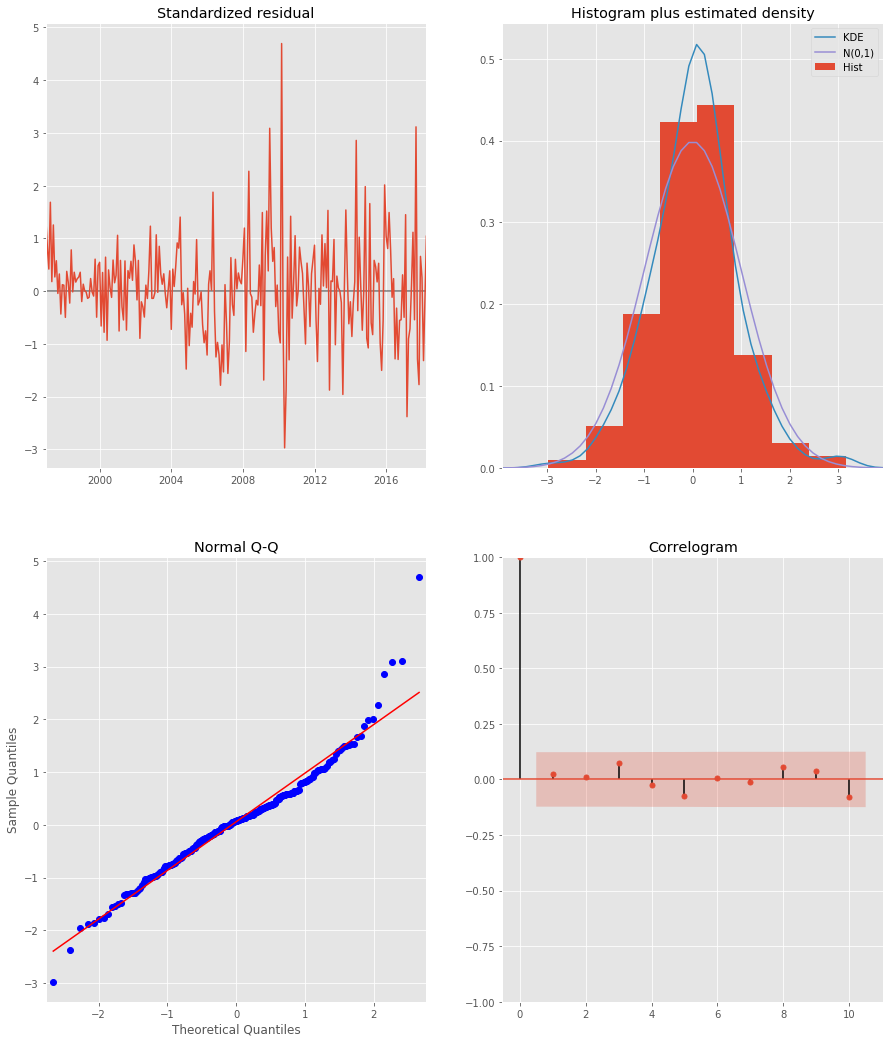

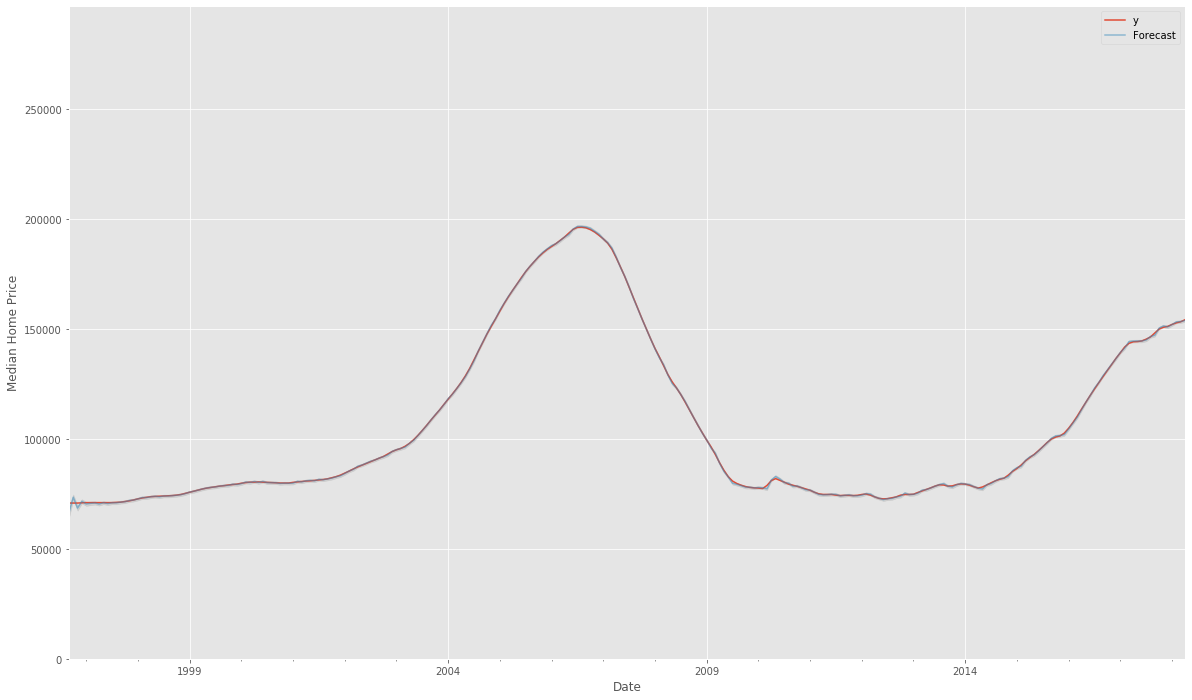

The Root Mean Squared Error of our forecasts is 464.72


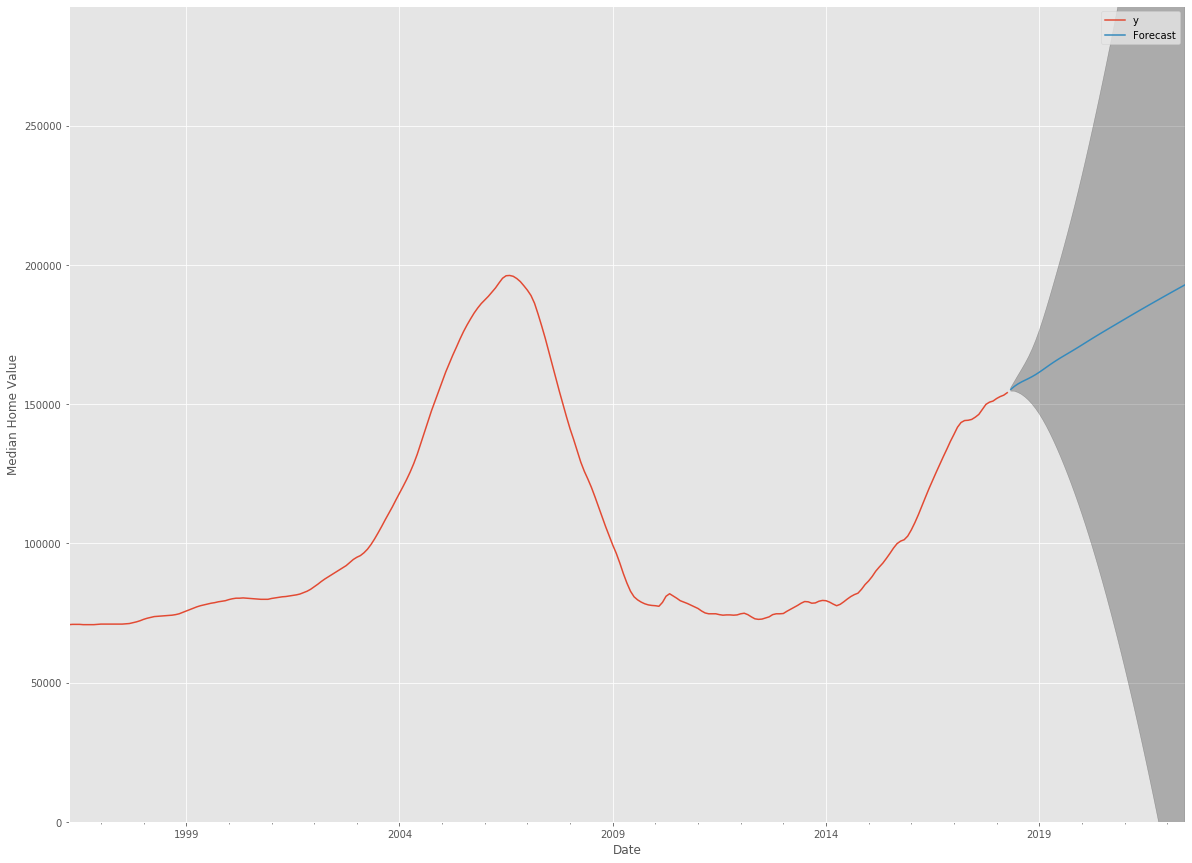

/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) : AIC Calculated =7074.615152706601
ARIMA (0, 0, 1) : AIC Calculated =6857.547683404462
ARIMA (0, 0, 2) : AIC Calculated =6789.309181899525


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 3) : AIC Calculated =8699.497020524868


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 4) : AIC Calculated =8000.339199446667


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (0, 0, 5) : AIC Calculated =7619.926301021484
ARIMA (0, 1, 0) : AIC Calculated =4659.383326773965
ARIMA (0, 1, 1) : AIC Calculated =4318.4777487280535
ARIMA (0, 1, 2) : AIC Calculated =4051.201056915829


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 3) : AIC Calculated =3950.2078146065587


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 4) : AIC Calculated =3875.0750511922324


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 5) : AIC Calculated =3899.887053106124
ARIMA (0, 2, 0) : AIC Calculated =3987.7594856004534
ARIMA (0, 2, 1) : AIC Calculated =3878.1693846587805
ARIMA (0, 2, 2) : AIC Calculated =3852.3521560691725
ARIMA (0, 2, 3) : AIC Calculated =3803.1558711065336


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 4) : AIC Calculated =3778.6471999193554
ARIMA (0, 2, 5) : AIC Calculated =3764.309387825917
ARIMA (0, 3, 0) : AIC Calculated =4012.3679539175155


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 3, 1) : AIC Calculated =3980.417477331179
ARIMA (0, 3, 2) : AIC Calculated =3854.973987044716


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 3, 3) : AIC Calculated =3831.2052213548795


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 3, 4) : AIC Calculated =3777.3428154419394


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 3, 5) : AIC Calculated =3760.5417294827457
ARIMA (0, 4, 0) : AIC Calculated =4127.931761797653
ARIMA (0, 4, 1) : AIC Calculated =4015.9601746648987


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 4, 2) : AIC Calculated =4006.674562455213
ARIMA (0, 4, 3) : AIC Calculated =3872.9284879202132


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 4, 4) : AIC Calculated =3829.441082465438


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 4, 5) : AIC Calculated =3790.644375383863
ARIMA (0, 5, 0) : AIC Calculated =4313.018009774908
ARIMA (0, 5, 1) : AIC Calculated =4117.843441732578


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 5, 2) : AIC Calculated =3995.9941787008065


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 5, 3) : AIC Calculated =4010.845850844752


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 5, 4) : AIC Calculated =3944.3795754846756


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 5, 5) : AIC Calculated =3866.067651604547
ARIMA (1, 0, 0) : AIC Calculated =4526.485589081947
ARIMA (1, 0, 1) : AIC Calculated =4204.289363358495


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 2) : AIC Calculated =3970.6130166254757


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 3) : AIC Calculated =3940.633010200082


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 4) : AIC Calculated =4099.3901677025115


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (1, 0, 5) : AIC Calculated =4075.9902707224373
ARIMA (1, 1, 0) : AIC Calculated =3999.0540116054144
ARIMA (1, 1, 1) : AIC Calculated =3889.116483256548
ARIMA (1, 1, 2) : AIC Calculated =3854.0082344048196
ARIMA (1, 1, 3) : AIC Calculated =3814.5851415449574
ARIMA (1, 1, 4) : AIC Calculated =3792.425675116542


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 5) : AIC Calculated =3778.2230332054683
ARIMA (1, 2, 0) : AIC Calculated =3942.158652051935
ARIMA (1, 2, 1) : AIC Calculated =3878.8501872788584


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) : AIC Calculated =3852.393774238326
ARIMA (1, 2, 3) : AIC Calculated =3799.55421590321


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 4) : AIC Calculated =3780.641039221285


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 5) : AIC Calculated =3765.5965980961673
ARIMA (1, 3, 0) : AIC Calculated =4009.5797076225535
ARIMA (1, 3, 1) : AIC Calculated =3933.1720206258365
ARIMA (1, 3, 2) : AIC Calculated =3853.330670195902


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 3, 3) : AIC Calculated =3822.2189336371584


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 3, 4) : AIC Calculated =3774.7170029615622


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 3, 5) : AIC Calculated =3760.6996238943016
ARIMA (1, 4, 0) : AIC Calculated =4126.619162408173
ARIMA (1, 4, 1) : AIC Calculated =4003.1927036680486
ARIMA (1, 4, 2) : AIC Calculated =4008.7042978550435


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 4, 3) : AIC Calculated =3852.572980773881


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 4, 4) : AIC Calculated =3820.2878234801346
ARIMA (1, 4, 5) : AIC Calculated =3787.0668400474756
ARIMA (1, 5, 0) : AIC Calculated =4282.590544701667
ARIMA (1, 5, 1) : AIC Calculated =4104.313748013141


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 5, 2) : AIC Calculated =3990.16900557995


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 5, 3) : AIC Calculated =3990.9867899333735


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 5, 4) : AIC Calculated =3946.7152183558655


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 5, 5) : AIC Calculated =3856.412730143176
ARIMA (2, 0, 0) : AIC Calculated =3997.8429980485294


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 1) : AIC Calculated =3985.6013030818062
ARIMA (2, 0, 2) : AIC Calculated =3875.8754327466086
ARIMA (2, 0, 3) : AIC Calculated =3847.2429515714825


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (2, 0, 4) : AIC Calculated =3810.149896207712
ARIMA (2, 0, 5) : AIC Calculated =3806.0442212792204
ARIMA (2, 1, 0) : AIC Calculated =3930.271968553171
ARIMA (2, 1, 1) : AIC Calculated =3886.5417670128536
ARIMA (2, 1, 2) : AIC Calculated =3869.5098258694316


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 3) : AIC Calculated =3814.755442175371


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 4) : AIC Calculated =3794.413199236672


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 5) : AIC Calculated =3781.0890059205904
ARIMA (2, 2, 0) : AIC Calculated =3822.6959386334906
ARIMA (2, 2, 1) : AIC Calculated =3824.403235016143
ARIMA (2, 2, 2) : AIC Calculated =3812.3983439106814


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 3) : AIC Calculated =3798.6265174710643


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 4) : AIC Calculated =3782.3970331682954


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 5) : AIC Calculated =3758.0382188757785
ARIMA (2, 3, 0) : AIC Calculated =3913.407119561681
ARIMA (2, 3, 1) : AIC Calculated =3875.127777776312
ARIMA (2, 3, 2) : AIC Calculated =3815.620520570214


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 3, 3) : AIC Calculated =3839.633444369051


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 3, 4) : AIC Calculated =3782.399939300455
ARIMA (2, 3, 5) : AIC Calculated =3766.797973198452
ARIMA (2, 4, 0) : AIC Calculated =4051.7823796537805
ARIMA (2, 4, 1) : AIC Calculated =3937.9959712983423


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 4, 2) : AIC Calculated =3892.0465185606245


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 4, 3) : AIC Calculated =3819.8178595205363


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 4, 4) : AIC Calculated =3822.5210358432737


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 4, 5) : AIC Calculated =3785.506437285715
ARIMA (2, 5, 0) : AIC Calculated =4207.470110003759
ARIMA (2, 5, 1) : AIC Calculated =4043.892595659108


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 5, 2) : AIC Calculated =3905.4049694068303


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 5, 3) : AIC Calculated =3927.1604678919357


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 5, 4) : AIC Calculated =3861.895375605904


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 5, 5) : AIC Calculated =3856.9364874739977
ARIMA (3, 0, 0) : AIC Calculated =3922.9593697833357
ARIMA (3, 0, 1) : AIC Calculated =3885.4858928540825


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 0, 2) : AIC Calculated =3878.302340238807


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 0, 3) : AIC Calculated =3851.1969955138493
ARIMA (3, 0, 4) : AIC Calculated =3822.402599262532


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 0, 5) : AIC Calculated =3803.4840239229106
ARIMA (3, 1, 0) : AIC Calculated =3821.0696301963435
ARIMA (3, 1, 1) : AIC Calculated =3822.623424604372


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 2) : AIC Calculated =3824.2887523569716
ARIMA (3, 1, 3) : AIC Calculated =3812.0375417153955


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 4) : AIC Calculated =3792.1745658221994


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (3, 1, 5) : AIC Calculated =3776.191226496758
ARIMA (3, 2, 0) : AIC Calculated =3810.7924711406417
ARIMA (3, 2, 1) : AIC Calculated =3812.6603355897078
ARIMA (3, 2, 2) : AIC Calculated =3812.972732479065


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 3) : AIC Calculated =3802.5156200607485
ARIMA (3, 2, 4) : AIC Calculated =3778.5216343941433


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 5) : AIC Calculated =3758.5031165197393
ARIMA (3, 3, 0) : AIC Calculated =3877.7511060004035
ARIMA (3, 3, 1) : AIC Calculated =3811.5574340035632


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 3, 2) : AIC Calculated =3806.204365123702


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 3, 3) : AIC Calculated =3809.8741549051265
ARIMA (3, 3, 4) : AIC Calculated =3782.452727295382


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 3, 5) : AIC Calculated =3763.914930845428
ARIMA (3, 4, 0) : AIC Calculated =3998.1378311965605
ARIMA (3, 4, 1) : AIC Calculated =3913.4959353422137


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 4, 2) : AIC Calculated =3889.8629789104507


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 4, 3) : AIC Calculated =3810.2123539612703


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 4, 4) : AIC Calculated =3815.181557257534


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 4, 5) : AIC Calculated =3779.3497156936173
ARIMA (3, 5, 0) : AIC Calculated =4125.517723240582
ARIMA (3, 5, 1) : AIC Calculated =3989.6876418501806


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 5, 2) : AIC Calculated =3931.8965839949756
ARIMA (3, 5, 3) : AIC Calculated =3914.4316352188926


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 5, 4) : AIC Calculated =3866.043033173383


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 5, 5) : AIC Calculated =3853.0354460855897
ARIMA (4, 0, 0) : AIC Calculated =3821.4602755653827


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 0, 1) : AIC Calculated =3889.1882263781768
ARIMA (4, 0, 2) : AIC Calculated =3829.058803036986


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 0, 3) : AIC Calculated =3829.0343234376855


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 0, 4) : AIC Calculated =3826.2605714694564


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 0, 5) : AIC Calculated =3813.6643564239885
ARIMA (4, 1, 0) : AIC Calculated =3808.9926323830796
ARIMA (4, 1, 1) : AIC Calculated =3810.9445569872673


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 1, 2) : AIC Calculated =3830.308016802967


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 1, 3) : AIC Calculated =3860.170692500903
ARIMA (4, 1, 4) : AIC Calculated =3792.502410421328


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 1, 5) : AIC Calculated =3773.3564165562625
ARIMA (4, 2, 0) : AIC Calculated =3798.1957374091626
ARIMA (4, 2, 1) : AIC Calculated =3800.0933462361368


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (4, 2, 2) : AIC Calculated =3805.9929565604452


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 2, 3) : AIC Calculated =3806.740511264095


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 2, 4) : AIC Calculated =3787.5099224931455


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 2, 5) : AIC Calculated =3760.8529026492383
ARIMA (4, 3, 0) : AIC Calculated =3850.390148997465
ARIMA (4, 3, 1) : AIC Calculated =3848.2113258225486
ARIMA (4, 3, 2) : AIC Calculated =3799.908431067295


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 3, 3) : AIC Calculated =3814.967222996739


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 3, 4) : AIC Calculated =3782.7781921562682


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 3, 5) : AIC Calculated =3763.4512305959133
ARIMA (4, 4, 0) : AIC Calculated =3966.676635148387
ARIMA (4, 4, 1) : AIC Calculated =3868.0019948713843


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 4, 2) : AIC Calculated =3825.7517601122236


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 4, 3) : AIC Calculated =3817.286833948481


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 4, 4) : AIC Calculated =3813.2214343417463


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 4, 5) : AIC Calculated =3780.7933182149545
ARIMA (4, 5, 0) : AIC Calculated =4093.6875393954283
ARIMA (4, 5, 1) : AIC Calculated =3960.486177290052


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 5, 2) : AIC Calculated =3909.562305485925


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 5, 3) : AIC Calculated =3905.621489036424
ARIMA (4, 5, 4) : AIC Calculated =3882.6180866438112


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 5, 5) : AIC Calculated =3838.9718046392495
ARIMA (5, 0, 0) : AIC Calculated =3809.122478627499
ARIMA (5, 0, 1) : AIC Calculated =3869.9599008252417


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 0, 2) : AIC Calculated =3865.8178206035827


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 0, 3) : AIC Calculated =5557.382486265409


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 0, 4) : AIC Calculated =3871.302036529909


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 0, 5) : AIC Calculated =3804.448803821199
ARIMA (5, 1, 0) : AIC Calculated =3796.775478100113
ARIMA (5, 1, 1) : AIC Calculated =3798.7773329816273


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 1, 2) : AIC Calculated =3800.7315695941143


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 1, 3) : AIC Calculated =4288.487436034904
ARIMA (5, 1, 4) : AIC Calculated =3789.329561349682


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (5, 1, 5) : AIC Calculated =3783.331002672234
ARIMA (5, 2, 0) : AIC Calculated =3786.083275031133
ARIMA (5, 2, 1) : AIC Calculated =3788.0751806881735
ARIMA (5, 2, 2) : AIC Calculated =3828.1693838991077


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 2, 3) : AIC Calculated =3816.1505297091244


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 2, 4) : AIC Calculated =3800.7776756237035


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 2, 5) : AIC Calculated =3766.201103528633
ARIMA (5, 3, 0) : AIC Calculated =3812.3581801088676
ARIMA (5, 3, 1) : AIC Calculated =3814.2554111081013
ARIMA (5, 3, 2) : AIC Calculated =3814.7862353909654


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 3, 3) : AIC Calculated =3811.606813323696
ARIMA (5, 3, 4) : AIC Calculated =3815.6173692747907


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (5, 3, 5) : AIC Calculated =3761.8107276560254
ARIMA (5, 4, 0) : AIC Calculated =3899.2105338539495
ARIMA (5, 4, 1) : AIC Calculated =3865.7883833759543


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 4, 2) : AIC Calculated =3855.5299827438275


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 4, 3) : AIC Calculated =3854.7018412528655


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 4, 4) : AIC Calculated =3856.1023532527583


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 4, 5) : AIC Calculated =3781.830851360411
ARIMA (5, 5, 0) : AIC Calculated =4014.9708563201793
ARIMA (5, 5, 1) : AIC Calculated =3897.2648994464944


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 5, 2) : AIC Calculated =3889.282178691993


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 5, 3) : AIC Calculated =3860.659951700185


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 5, 4) : AIC Calculated =3851.2048219834696


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 5, 5) : AIC Calculated =3830.931189990075
pdq    (2, 2, 5)
aic      3758.04
Name: 89, dtype: object


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3443      0.018     75.801      0.000       1.310       1.379
ar.L2         -0.9495      0.016    -59.560      0.000      -0.981      -0.918
ma.L1         -0.6739      0.093     -7.280      0.000      -0.855      -0.492
ma.L2         -0.1739      0.074     -2.342      0.019      -0.319      -0.028
ma.L3          0.5119      0.093      5.496      0.000       0.329       0.694
ma.L4          0.4245      0.064      6.613      0.000       0.299       0.550
ma.L5         -0.2870      0.053     -5.383      0.000      -0.392      -0.183
sigma2      1.185e+05   1.32e+04      9.003      0.000    9.27e+04    1.44e+05


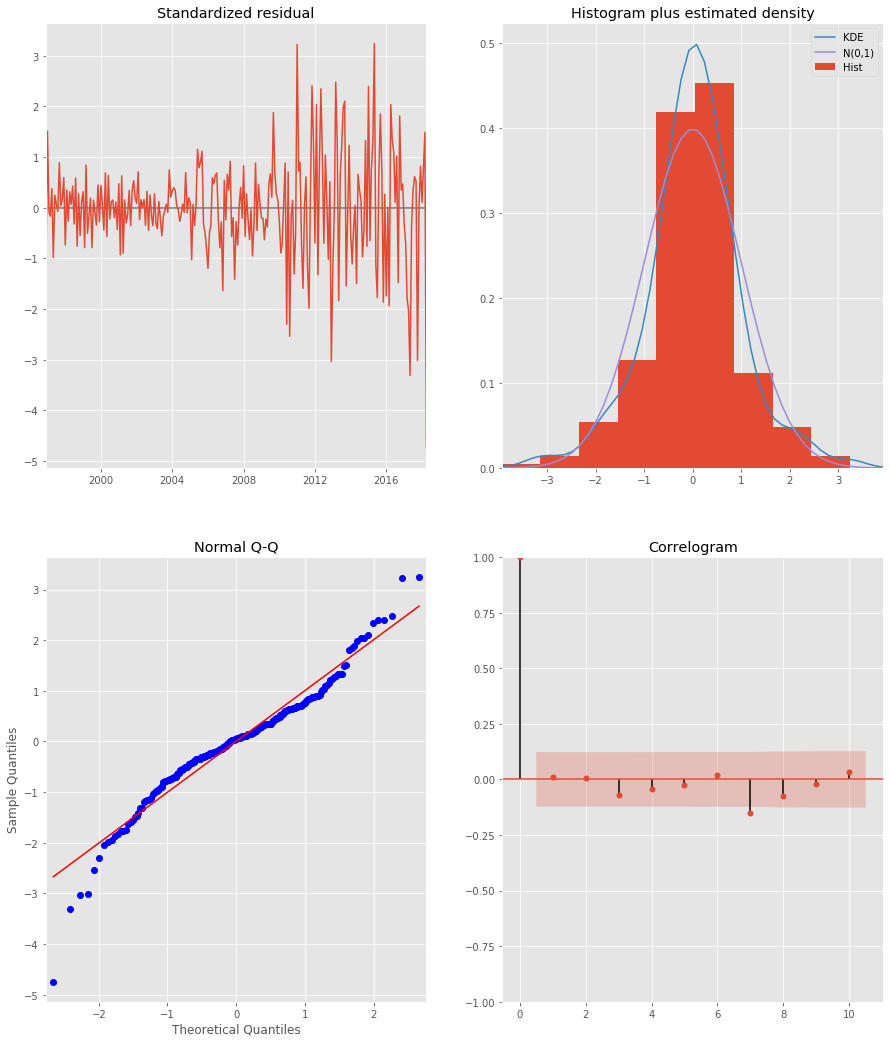

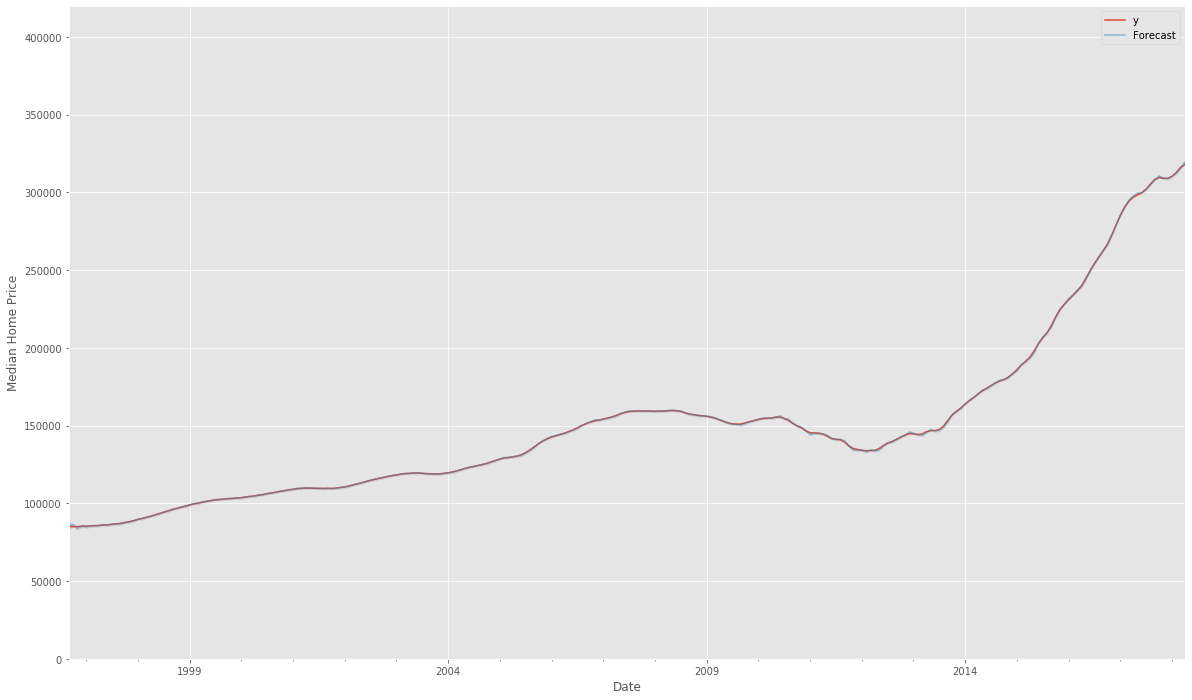

The Root Mean Squared Error of our forecasts is 364.75


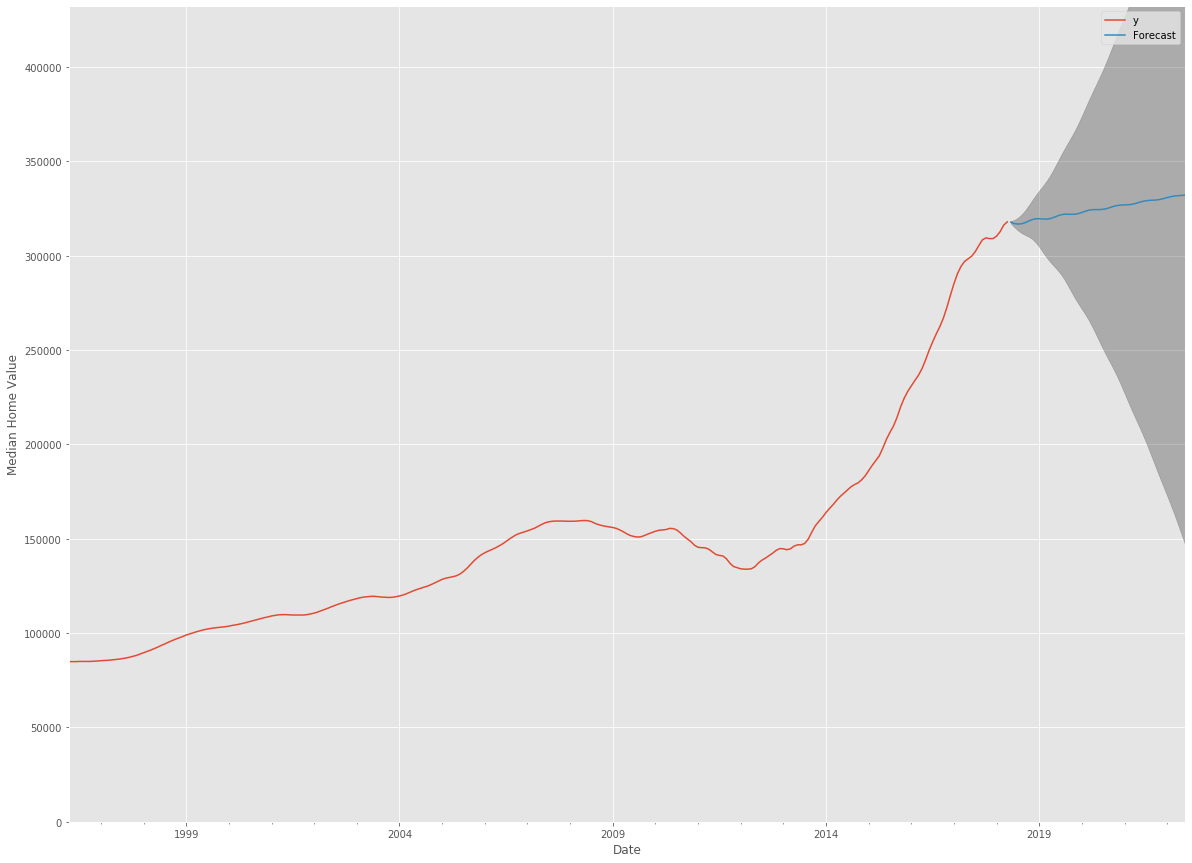

/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) : AIC Calculated =6695.3792264607155
ARIMA (0, 0, 1) : AIC Calculated =6479.882111199229
ARIMA (0, 0, 2) : AIC Calculated =6412.920342436911


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 3) : AIC Calculated =7914.6410257965845


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 4) : AIC Calculated =7428.036157706607


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 5) : AIC Calculated =7167.897108282052
ARIMA (0, 1, 0) : AIC Calculated =4456.827788905307
ARIMA (0, 1, 1) : AIC Calculated =4149.407556049664
ARIMA (0, 1, 2) : AIC Calculated =3925.9888021450047


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 3) : AIC Calculated =3844.6707544663886


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 4) : AIC Calculated =3822.546580546005


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (0, 1, 5) : AIC Calculated =3793.1446828157814
ARIMA (0, 2, 0) : AIC Calculated =3919.989560805165
ARIMA (0, 2, 1) : AIC Calculated =3833.071137134894
ARIMA (0, 2, 2) : AIC Calculated =3819.8223654270987
ARIMA (0, 2, 3) : AIC Calculated =3756.474885206099
ARIMA (0, 2, 4) : AIC Calculated =3738.408157091713


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 5) : AIC Calculated =3724.570481048321
ARIMA (0, 3, 0) : AIC Calculated =3968.961224147573
ARIMA (0, 3, 1) : AIC Calculated =3929.682636360021


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 3, 2) : AIC Calculated =3810.2641062022
ARIMA (0, 3, 3) : AIC Calculated =3800.155829674847


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 3, 4) : AIC Calculated =3736.9217094102287


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 3, 5) : AIC Calculated =3720.1484798289725
ARIMA (0, 4, 0) : AIC Calculated =4112.588077658245
ARIMA (0, 4, 1) : AIC Calculated =3967.649371237706
ARIMA (0, 4, 2) : AIC Calculated =3947.825946426885


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 4, 3) : AIC Calculated =3834.605952630459


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 4, 4) : AIC Calculated =3802.832901254532


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 4, 5) : AIC Calculated =3742.844128461875
ARIMA (0, 5, 0) : AIC Calculated =4286.669277970119
ARIMA (0, 5, 1) : AIC Calculated =4094.1274199449635


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 5, 2) : AIC Calculated =3929.885637774641


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 5, 3) : AIC Calculated =3978.385999460059


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 5, 4) : AIC Calculated =3902.0667205640057


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (0, 5, 5) : AIC Calculated =3839.8123674153385
ARIMA (1, 0, 0) : AIC Calculated =4294.766342839622
ARIMA (1, 0, 1) : AIC Calculated =4060.505101272784
ARIMA (1, 0, 2) : AIC Calculated =3839.2848167542443


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 3) : AIC Calculated =3866.9396885806195


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 4) : AIC Calculated =3826.013886621731


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (1, 0, 5) : AIC Calculated =3867.02043660713
ARIMA (1, 1, 0) : AIC Calculated =3934.6477791257553
ARIMA (1, 1, 1) : AIC Calculated =3838.928722868397
ARIMA (1, 1, 2) : AIC Calculated =3818.067534902535
ARIMA (1, 1, 3) : AIC Calculated =3772.2071746969486


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 4) : AIC Calculated =3754.2926768616726


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 5) : AIC Calculated =3740.6085661660222
ARIMA (1, 2, 0) : AIC Calculated =3884.938367983602
ARIMA (1, 2, 1) : AIC Calculated =3834.108244071688
ARIMA (1, 2, 2) : AIC Calculated =3796.718201643229


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 3) : AIC Calculated =3754.206042321198


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 4) : AIC Calculated =3739.728481945069


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 5) : AIC Calculated =3719.4934803273663
ARIMA (1, 3, 0) : AIC Calculated =3970.7683997123877
ARIMA (1, 3, 1) : AIC Calculated =3869.100561319073


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 3, 2) : AIC Calculated =3812.0836219481052


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 3, 3) : AIC Calculated =3796.2076925850874


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 3, 4) : AIC Calculated =3735.817045521061


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/

ARIMA (1, 3, 5) : AIC Calculated =3717.7155910061574
ARIMA (1, 4, 0) : AIC Calculated =4104.398661748497
ARIMA (1, 4, 1) : AIC Calculated =3951.4088755273992
ARIMA (1, 4, 2) : AIC Calculated =3937.6741305315127


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 4, 3) : AIC Calculated =3796.1991839542206


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 4, 4) : AIC Calculated =3796.9972103140562


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 4, 5) : AIC Calculated =3743.31620718282
ARIMA (1, 5, 0) : AIC Calculated =4250.967020818873
ARIMA (1, 5, 1) : AIC Calculated =4083.8089504830205
ARIMA (1, 5, 2) : AIC Calculated =3931.7678644380853


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 5, 3) : AIC Calculated =3965.76452871439


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 5, 4) : AIC Calculated =3893.8723331743054
ARIMA (1, 5, 5) : AIC Calculated =3842.4694361077845
ARIMA (2, 0, 0) : AIC Calculated =3927.971897406797
ARIMA (2, 0, 1) : AIC Calculated =3864.2616074990315


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 2) : AIC Calculated =3808.995842199775


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 3) : AIC Calculated =3799.424950274456


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 4) : AIC Calculated =3768.6547358650714


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 0, 5) : AIC Calculated =3754.867136557515
ARIMA (2, 1, 0) : AIC Calculated =3874.2916499209528
ARIMA (2, 1, 1) : AIC Calculated =3840.5060302232905


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) : AIC Calculated =3811.343561368494


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 3) : AIC Calculated =3773.6499178395043


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 4) : AIC Calculated =3765.3306765153043


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 5) : AIC Calculated =3734.712145176921
ARIMA (2, 2, 0) : AIC Calculated =3801.3865154046252
ARIMA (2, 2, 1) : AIC Calculated =3803.370880584129
ARIMA (2, 2, 2) : AIC Calculated =3785.8915544920837


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 3) : AIC Calculated =3753.933269283897


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 4) : AIC Calculated =3755.456047358323


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 5) : AIC Calculated =3708.445492633269
ARIMA (2, 3, 0) : AIC Calculated =3886.8881896228336
ARIMA (2, 3, 1) : AIC Calculated =3811.7195046123256


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 3, 2) : AIC Calculated =3787.3422733830735


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 3, 3) : AIC Calculated =3792.6328307786653


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 3, 4) : AIC Calculated =3734.0785395812686


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 3, 5) : AIC Calculated =3712.5884248684238
ARIMA (2, 4, 0) : AIC Calculated =4019.2270756692833
ARIMA (2, 4, 1) : AIC Calculated =3886.8706244454343


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 4, 2) : AIC Calculated =3802.384379444118
ARIMA (2, 4, 3) : AIC Calculated =3791.617298123159


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 4, 4) : AIC Calculated =3762.818052512932


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 4, 5) : AIC Calculated =3748.6725279926177
ARIMA (2, 5, 0) : AIC Calculated =4173.700515294517
ARIMA (2, 5, 1) : AIC Calculated =4010.792098138605


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 5, 2) : AIC Calculated =3866.520074842307


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 5, 3) : AIC Calculated =3884.625921680632
ARIMA (2, 5, 4) : AIC Calculated =3842.5754865552753


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 5, 5) : AIC Calculated =3816.683242562057
ARIMA (3, 0, 0) : AIC Calculated =3851.1367541571144
ARIMA (3, 0, 1) : AIC Calculated =3823.9347713523393


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 0, 2) : AIC Calculated =3809.745843277479
ARIMA (3, 0, 3) : AIC Calculated =3800.365681230699


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 0, 4) : AIC Calculated =3908.4425631620043
ARIMA (3, 0, 5) : AIC Calculated =3846.128188107523
ARIMA (3, 1, 0) : AIC Calculated =3800.518815792908
ARIMA (3, 1, 1) : AIC Calculated =3802.4882701452857


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 2) : AIC Calculated =3796.2572985214947


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 3) : AIC Calculated =3775.118693094902


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 4) : AIC Calculated =3753.4116307283466


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 5) : AIC Calculated =3724.3574229068663
ARIMA (3, 2, 0) : AIC Calculated =3789.744425998997
ARIMA (3, 2, 1) : AIC Calculated =3790.877427468222
ARIMA (3, 2, 2) : AIC Calculated =3780.2253528928577
ARIMA (3, 2, 3) : AIC Calculated =3755.709333471656


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 4) : AIC Calculated =3729.861742567923


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 5) : AIC Calculated =3710.0463144125665
ARIMA (3, 3, 0) : AIC Calculated =3866.1097323212753
ARIMA (3, 3, 1) : AIC Calculated =3787.0194096034884


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 3, 2) : AIC Calculated =3773.491460694703


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 3, 3) : AIC Calculated =3760.531259432907
ARIMA (3, 3, 4) : AIC Calculated =3735.8387516563325


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 3, 5) : AIC Calculated =3713.2842500468023
ARIMA (3, 4, 0) : AIC Calculated =3971.5337957660518
ARIMA (3, 4, 1) : AIC Calculated =3868.127153953135


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 4, 2) : AIC Calculated =3843.434970572758


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 4, 3) : AIC Calculated =3781.524361930539


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 4, 4) : AIC Calculated =3770.1866879828185


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 4, 5) : AIC Calculated =3734.6692036674567
ARIMA (3, 5, 0) : AIC Calculated =4092.189348141343
ARIMA (3, 5, 1) : AIC Calculated =3963.3259469239665


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 5, 2) : AIC Calculated =3898.324644372431


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 5, 3) : AIC Calculated =3884.425918012056


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 5, 4) : AIC Calculated =3836.765729317567


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 5, 5) : AIC Calculated =3807.8462470480217
ARIMA (4, 0, 0) : AIC Calculated =3792.5515572239256


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 0, 1) : AIC Calculated =3838.616361565106
ARIMA (4, 0, 2) : AIC Calculated =3812.5467495085395
ARIMA (4, 0, 3) : AIC Calculated =3819.038134072527


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 0, 4) : AIC Calculated =3779.0210343444023


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 0, 5) : AIC Calculated =3811.213781258629
ARIMA (4, 1, 0) : AIC Calculated =3788.665862941374
ARIMA (4, 1, 1) : AIC Calculated =3789.5422011209903


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 1, 2) : AIC Calculated =3792.2163138597716


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 1, 3) : AIC Calculated =3776.923751577244
ARIMA (4, 1, 4) : AIC Calculated =3744.915935150083


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 1, 5) : AIC Calculated =3731.954476778539
ARIMA (4, 2, 0) : AIC Calculated =3765.9230331310887
ARIMA (4, 2, 1) : AIC Calculated =3756.0047260710244


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 2, 2) : AIC Calculated =3757.7272768464754
ARIMA (4, 2, 3) : AIC Calculated =3760.244776564693


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 2, 4) : AIC Calculated =3735.11035633679


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 2, 5) : AIC Calculated =3707.6781776953085
ARIMA (4, 3, 0) : AIC Calculated =3846.2479701082902
ARIMA (4, 3, 1) : AIC Calculated =3777.2486915777954


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 3, 2) : AIC Calculated =3768.494608014971


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 3, 3) : AIC Calculated =3783.4995925460626


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 3, 4) : AIC Calculated =3738.1046866786055


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 3, 5) : AIC Calculated =3713.8581140545994
ARIMA (4, 4, 0) : AIC Calculated =3949.6324794287243
ARIMA (4, 4, 1) : AIC Calculated =3845.5797730816676


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 4, 2) : AIC Calculated =3808.031661540691


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 4, 3) : AIC Calculated =3876.755884493952


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 4, 4) : AIC Calculated =3770.515174431761


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 4, 5) : AIC Calculated =3736.917982348059
ARIMA (4, 5, 0) : AIC Calculated =4063.7488184384356
ARIMA (4, 5, 1) : AIC Calculated =3941.860304920011


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 5, 2) : AIC Calculated =3954.831445075937


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 5, 3) : AIC Calculated =3883.7162720475317


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (4, 5, 4) : AIC Calculated =3857.0033321690116
ARIMA (4, 5, 5) : AIC Calculated =3814.530715342043
ARIMA (5, 0, 0) : AIC Calculated =3779.77908807765


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 0, 1) : AIC Calculated =3818.3627337913463
ARIMA (5, 0, 2) : AIC Calculated =3814.926855970052


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 0, 3) : AIC Calculated =4053.3953116557636


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 0, 4) : AIC Calculated =3778.613000490328


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmo

ARIMA (5, 0, 5) : AIC Calculated =3766.8439680151746
ARIMA (5, 1, 0) : AIC Calculated =3766.6950529630703
ARIMA (5, 1, 1) : AIC Calculated =3756.9377523652647


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 1, 2) : AIC Calculated =3771.186127984575


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 1, 3) : AIC Calculated =3758.582540033109


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 1, 4) : AIC Calculated =3738.3467140202547


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 1, 5) : AIC Calculated =3722.7946420183844
ARIMA (5, 2, 0) : AIC Calculated =3737.467265171569
ARIMA (5, 2, 1) : AIC Calculated =3739.1360386152937
ARIMA (5, 2, 2) : AIC Calculated =3740.415515712267


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 2, 3) : AIC Calculated =3755.78249511553


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 2, 4) : AIC Calculated =3740.4596202821567


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 2, 5) : AIC Calculated =3709.5206765665016
ARIMA (5, 3, 0) : AIC Calculated =3805.170740275201
ARIMA (5, 3, 1) : AIC Calculated =3741.8874601005978


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 3, 2) : AIC Calculated =3738.687556666653


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 3, 3) : AIC Calculated =3729.1263716710137
ARIMA (5, 3, 4) : AIC Calculated =3737.9913782113813


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 3, 5) : AIC Calculated =3715.8210309092474
ARIMA (5, 4, 0) : AIC Calculated =3902.56272862587
ARIMA (5, 4, 1) : AIC Calculated =3807.1828242266347


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 4, 2) : AIC Calculated =3793.3615159993096


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 4, 3) : AIC Calculated =3837.5717712571322


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 4, 4) : AIC Calculated =3763.115407168351


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 4, 5) : AIC Calculated =3732.061972293099
ARIMA (5, 5, 0) : AIC Calculated =4006.629909035292
ARIMA (5, 5, 1) : AIC Calculated =3894.9708126694827


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 5, 2) : AIC Calculated =3865.0471196079116


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 5, 3) : AIC Calculated =3927.820003891745


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 5, 4) : AIC Calculated =3833.812940254684


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (5, 5, 5) : AIC Calculated =3816.1979232860194
pdq    (4, 2, 5)
aic      3707.68
Name: 161, dtype: object


/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4968      0.184      8.116      0.000       1.135       1.858
ar.L2         -1.1366      0.259     -4.396      0.000      -1.643      -0.630
ar.L3          0.4366      0.234      1.870      0.062      -0.021       0.894
ar.L4         -0.3096      0.150     -2.070      0.038      -0.603      -0.017
ma.L1         -1.0173      0.182     -5.578      0.000      -1.375      -0.660
ma.L2         -0.0883      0.191     -0.462      0.644      -0.463       0.286
ma.L3          0.1861      0.201      0.924      0.356      -0.209       0.581
ma.L4          0.5752      0.112      5.137      0.000       0.356       0.795
ma.L5         -0.2427      0.140     -1.735      0.083      -0.517       0.032
sigma2       1.08e+05   9277.868     11.639      0.000    8.98e+04    1.26e+05


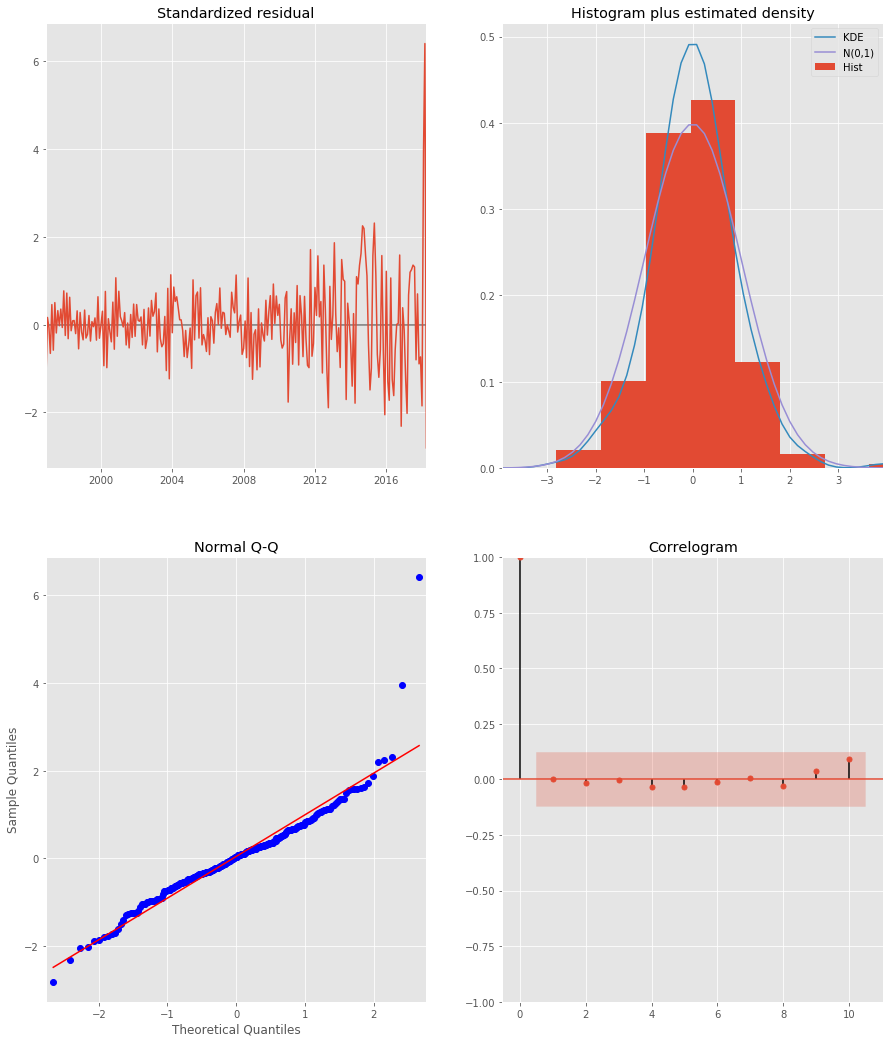

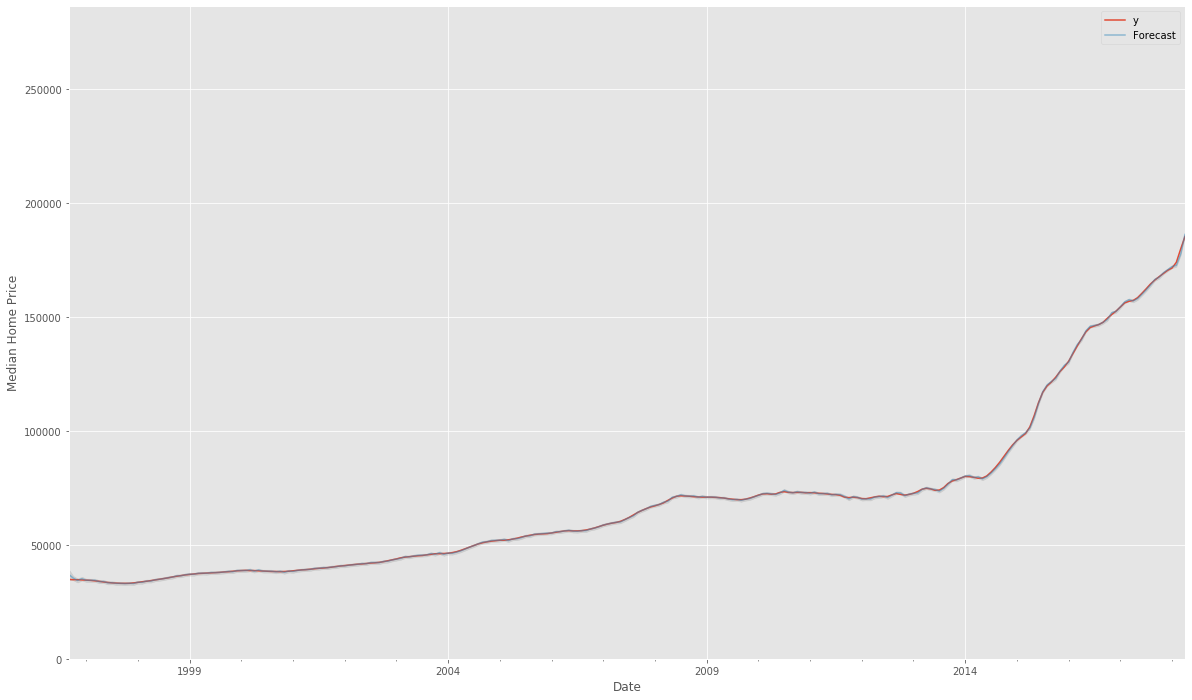

The Root Mean Squared Error of our forecasts is 342.42


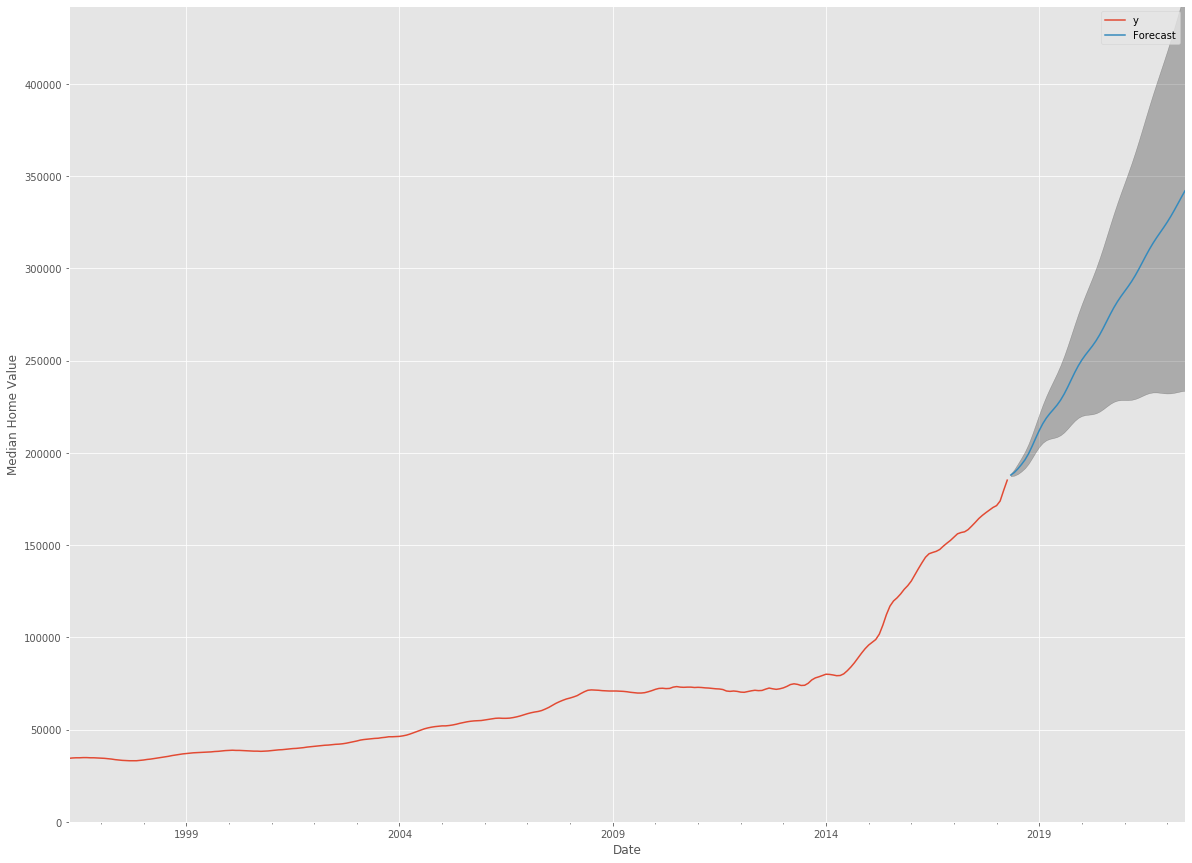

In [61]:
for zipcode in zipcodes:
    ARIMA_Analysis(df, zipcode, 6, 50)